# Experiment: SLAM (v4)
Here I'm looking at formulising the idea of using the model to occasionally regenerate the training data input maps.

In [ ]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo

# lock to revision
#!cd repo && git checkout e33eb2b
!cd repo && git pull

import sys
sys.path.append('repo')

from general_utils import display_history
import lds
import slam
import slam_data
import slam_data_test
from importlib import reload
reload(lds)
reload(slam)
reload(slam_data)
reload(slam_data_test)

Cloning into 'repo'...
remote: Enumerating objects: 565, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 565 (delta 36), reused 38 (delta 32), pack-reused 518 (from 1)
Receiving objects: 100% (565/565), 40.45 MiB | 39.38 MiB/s, done.
Resolving deltas: 100% (303/303), done.
Already up to date.


<module 'slam_data_test' from '/content/repo/slam_data_test.py'>

In [ ]:
!pip install -Uqq ipdb

from collections import namedtuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import io
import os
import shutil
import tarfile
import cv2
import requests
import math
import ipdb
import tqdm
import time
import gc
import datetime
from timeit import default_timer as timer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.6 MB/s eta 0:00:00


In [ ]:
# Load floorplan
floorplan = Image.open('repo/data/experimental-floorplan2.png')
floorplan = np.array(floorplan, dtype=np.uint8)
print(f"RGB encoded:     shape={floorplan.shape}, dtype={floorplan.dtype}, value range: {np.min(floorplan)} - {np.max(floorplan)}")
floorplan = slam_data.one_hot_encode_floorplan(floorplan).numpy()
print(f"one-hot encoded: shape={floorplan.shape}, dtype={floorplan.dtype}, value range: {np.min(floorplan)} - {np.max(floorplan)}")

RGB encoded:     shape=(139, 294, 3), dtype=uint8, value range: 0 - 255
one-hot encoded: shape=(139, 294, 3), dtype=float32, value range: 0.0 - 1.0


In [ ]:
# Load training data
train_data = slam_data.load_dataset('repo/data/experimental-slam-training-data4.npz')

Loaded:
  input_maps:  (1000, 159, 159, 3) x float32
  lds_maps:    (1000, 159, 159) x float32
  output_maps: (1000, 159, 159, 3) x float32
  adlos:       (1000, 4) x float32
  metadatas:   (1000, 8) x float32
Dataset loaded from repo/data/experimental-slam-training-data4.npz


In [ ]:
# Load initial model
model = tf.keras.models.load_model('experimental-slam-model3-50epochs.keras')

## Baseline
Simple dataset iteration


In [ ]:
# iterating one sample at a time
for i in range(10):
  start = timer()
  count = 0
  for (input_map, lds_map), (output_map, output_adlo), metadata in train_data:
      count += 1
  duration = (timer() - start)
  print(f"iterated {count} times in duration: {duration} sec")

iterated 1000 times in duration: 0.7834749649999821 sec
iterated 1000 times in duration: 1.269631411999967 sec
iterated 1000 times in duration: 1.2621177610000132 sec
iterated 1000 times in duration: 0.595169118000058 sec
iterated 1000 times in duration: 0.5715427000000091 sec
iterated 1000 times in duration: 0.5782982860000629 sec
iterated 1000 times in duration: 0.561475492999989 sec
iterated 1000 times in duration: 0.58194446899995 sec
iterated 1000 times in duration: 0.5658674630000178 sec
iterated 1000 times in duration: 0.5817690799999582 sec


In [ ]:
# iterating by batch
for i in range(10):
  start = timer()
  count = 0
  for (input_map, lds_map), (output_map, output_adlo), metadata in train_data.batch(32):
      count += 1
  duration = (timer() - start)
  print(f"iterated {count} times in duration: {duration} sec")

iterated 32 times in duration: 0.9040662400000201 sec
iterated 32 times in duration: 0.8873992680000811 sec
iterated 32 times in duration: 0.909232220000149 sec
iterated 32 times in duration: 0.8513878879998629 sec
iterated 32 times in duration: 1.15368658400007 sec
iterated 32 times in duration: 0.8604072799998903 sec
iterated 32 times in duration: 1.2438625770000726 sec
iterated 32 times in duration: 1.4393202530000053 sec
iterated 32 times in duration: 1.2760684769998534 sec
iterated 32 times in duration: 0.9461815779998233 sec


In [ ]:
# iteration with map function
print(f"Setting new mapped dataset each time")
for i in range(10):
  start = timer()
  count = 0
  ds = train_data.map(lambda inputs, outputs, metadata: (inputs, outputs))
  for (input_map, lds_map), (output_map, output_adlo) in ds.batch(32):
      count += 1
  duration = (timer() - start)
  print(f"iterated {count} times in duration: {duration} sec")

print(f"Sharing mapped dataset")
ds = train_data.map(lambda inputs, outputs, metadata: (inputs, outputs))
for i in range(10):
  start = timer()
  count = 0
  for (input_map, lds_map), (output_map, output_adlo) in ds.batch(32):
      count += 1
  duration = (timer() - start)
  print(f"iterated {count} times in duration: {duration} sec")

Setting new mapped dataset each time
iterated 1000 times in duration: 1.2496755590000248 sec
iterated 1000 times in duration: 1.2010540060000494 sec
iterated 1000 times in duration: 1.2241165389998514 sec
iterated 1000 times in duration: 1.8238477639999928 sec
iterated 1000 times in duration: 2.114683045999982 sec
iterated 1000 times in duration: 1.206054215999984 sec
iterated 1000 times in duration: 1.1951814910000849 sec
iterated 1000 times in duration: 1.190226536999944 sec
iterated 1000 times in duration: 1.1607141529998444 sec
iterated 1000 times in duration: 1.1735059329998876 sec
Sharing mapped dataset
iterated 1000 times in duration: 1.1694766000000527 sec
iterated 1000 times in duration: 0.6287542140003097 sec
iterated 1000 times in duration: 0.6277864210001098 sec
iterated 1000 times in duration: 0.6305799439996917 sec
iterated 1000 times in duration: 0.6140578299996378 sec
iterated 1000 times in duration: 1.268923518000065 sec
iterated 1000 times in duration: 1.2712989060000

In [ ]:
gc.collect()

612

## Dataset Revisor
Verify that it's basically working

In [ ]:
revisor = slam_data.DatasetRevisor(floorplan, model)

In [ ]:
revisor.prepare()

Generating 85 LDS maps...
Generating semantic maps...
3/3 ━━━━━━━━━━━━━━━━━━━━ 47s 14s/step


In [ ]:
print("Prepared:")
print(f"sample_locations: {revisor._sample_locations.shape} x {revisor._sample_locations.dtype}")
print(f"sample_maps:      {revisor._sample_maps.shape} x {revisor._sample_maps.dtype}")


Prepared:
sample_locations: (85, 2) x float64
sample_maps:      (85, 149, 149, 3) x <dtype: 'float32'>


input_map:  (159, 159, 3)
lds_map:    (159, 159)
output_map: (159, 159, 3)
adlo:       [1. 0. 0. 0.]
metadata:   [2.0000000e+00 0.0000000e+00           nan           nan           nan
 7.7704326e+03 5.2244917e+03 2.2490387e+00]


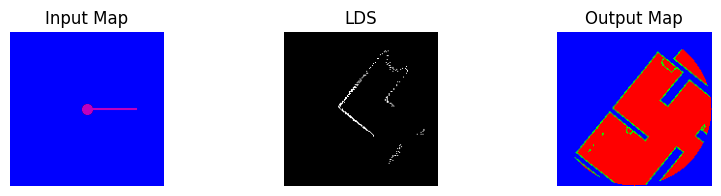

input_map:  (159, 159, 3)
lds_map:    (159, 159)
output_map: (159, 159, 3)
adlo:       [ 1.          0.06650611 -0.1320825  -0.31531525]
metadata:   [2.0000000e+00 2.0000000e+00 1.2393085e+04 1.5160209e+03 0.0000000e+00
 1.2865870e+04 5.7706079e+02 2.2837534e+00]


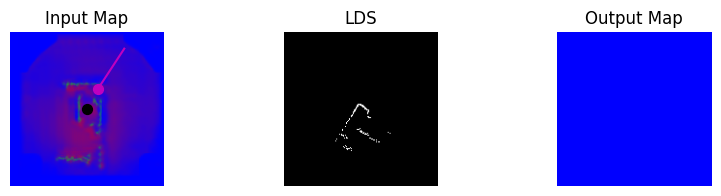

input_map:  (159, 159, 3)
lds_map:    (159, 159)
output_map: (159, 159, 3)
adlo:       [ 1.          0.08753846  0.48659375 -0.07261062]
metadata:   [2.0000000e+00 2.0000000e+00 5.3261099e+03 1.4369366e+03 0.0000000e+00
 5.9484111e+03 4.8960781e+03 1.1705631e+00]


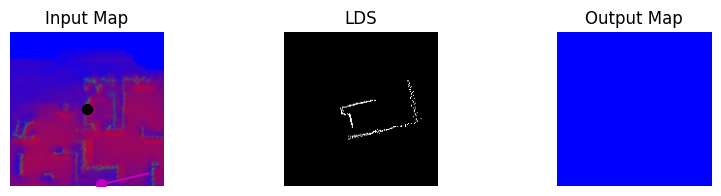

input_map:  (159, 159, 3)
lds_map:    (159, 159)
output_map: (159, 159, 3)
adlo:       [1. 0. 0. 0.]
metadata:   [2.0000000e+00 0.0000000e+00           nan           nan           nan
 1.1377892e+04 1.6338907e+03 2.9138200e+00]


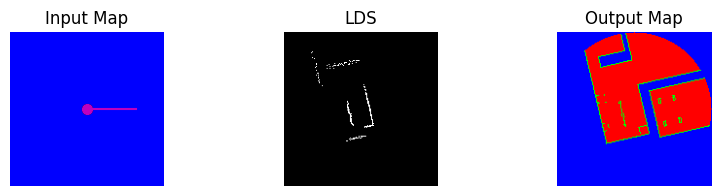

input_map:  (159, 159, 3)
lds_map:    (159, 159)
output_map: (159, 159, 3)
adlo:       [ 1.         -0.04257149 -0.08866958  0.0635903 ]
metadata:   [ 2.0000000e+00  1.0000000e+00  3.1065562e+03  5.0983755e+03
  0.0000000e+00  2.8039202e+03  4.4680332e+03 -4.6301708e-01]


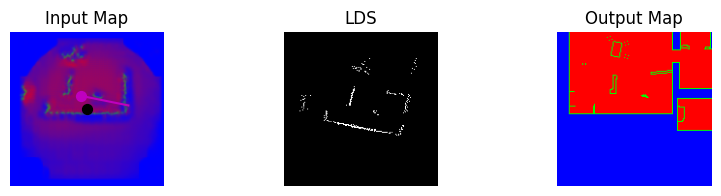

input_map:  (159, 159, 3)
lds_map:    (159, 159)
output_map: (159, 159, 3)
adlo:       [1. 0. 0. 0.]
metadata:   [ 2.0000000e+00  0.0000000e+00            nan            nan
            nan  9.1949268e+03  1.1775712e+03 -1.0998367e+00]


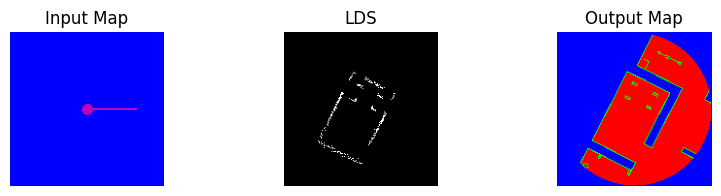

input_map:  (159, 159, 3)
lds_map:    (159, 159)
output_map: (159, 159, 3)
adlo:       [ 1.0000000e+00 -4.5766373e-04  2.0432066e-02  4.3668937e-02]
metadata:   [ 2.0000000e+00  1.0000000e+00  1.1190451e+04  2.4545078e+03
  0.0000000e+00  1.1187198e+04  2.5997571e+03 -5.7919192e-01]


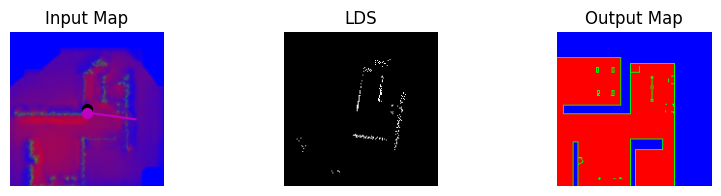

input_map:  (159, 159, 3)
lds_map:    (159, 159)
output_map: (159, 159, 3)
adlo:       [ 1.         -0.02623202 -0.06905483  0.02933878]
metadata:   [2.0000000e+00 1.0000000e+00 9.9319688e+03 6.1553672e+03 0.0000000e+00
 9.7454883e+03 5.6644639e+03 5.9592706e-01]


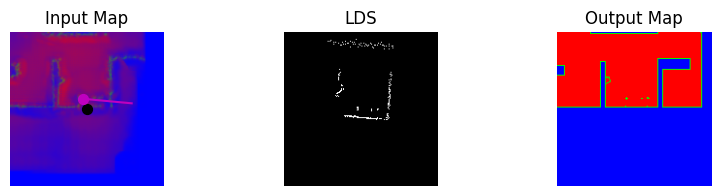

In [ ]:
reload(slam_data)
ds = train_data.map(revisor.map)
slam_data.show_dataset(ds, num=8)

In [ ]:
# prove that we can combine map functions for training time
reload(slam_data)
ds = train_data.map(revisor.map).map(slam_data.for_model_training)
for (input_map, lds_map), (output_map, output_adlo) in ds.take(3):
  print(f"input_map: {input_map.shape} x {input_map.dtype}")

input_map: (159, 159, 3) x <dtype: 'float32'>
input_map: (159, 159, 3) x <dtype: 'float32'>
input_map: (159, 159, 3) x <dtype: 'float32'>


In [ ]:
# checking performance
# iteration with map function
print(f"Setting new mapped dataset each time")
for i in range(4):
  start = timer()
  count = 0
  ds = train_data.map(revisor.map)
  for (input_map, lds_map), (output_map, output_adlo), metadata in ds.batch(32):
      count += 1
  duration = (timer() - start)
  print(f"iterated {count} times in duration: {duration} sec")

print(f"Sharing mapped dataset")
ds = train_data.map(revisor.map)
for i in range(4):
  start = timer()
  count = 0
  for (input_map, lds_map), (output_map, output_adlo), metadata in ds.batch(32):
      count += 1
  duration = (timer() - start)
  print(f"iterated {count} times in duration: {duration} sec")

Setting new mapped dataset each time
iterated 32 times in duration: 11.778141270999186 sec
iterated 32 times in duration: 21.351156109998556 sec
iterated 32 times in duration: 21.494693885000743 sec
iterated 32 times in duration: 11.698418590000074 sec
Sharing mapped dataset
iterated 32 times in duration: 12.92947062500025 sec
iterated 32 times in duration: 9.844602057000884 sec
iterated 32 times in duration: 21.28532696199909 sec
iterated 32 times in duration: 21.286555218001013 sec


### On GPU
The following were all executed with a GPU available.
I'm intentionally not doing anything to force it to use the GPU though, to emulate what'll happen during training.

In [ ]:
# Preparing
start = timer()
revisor = slam_data.DatasetRevisor(floorplan, model)
revisor.prepare()
duration = (timer() - start)
print(f"Prepared in {duration} sec:")
print(f"sample_locations: {revisor._sample_locations.shape} x {revisor._sample_locations.dtype}")
print(f"sample_maps:      {revisor._sample_maps.shape} x {revisor._sample_maps.dtype}")

Generating 81 LDS maps...
Generating semantic maps...
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step
Prepared in 10.606109076000052 sec:
sample_locations: (81, 2) x float32
sample_maps:      (81, 149, 149, 3) x <dtype: 'float32'>


In [ ]:
print(f"Setting new mapped dataset each time")
for i in range(4):
  start = timer()
  count = 0
  ds = train_data.map(revisor.map)
  for (input_map, lds_map), (output_map, output_adlo), metadata in ds.batch(32):
      count += 1
  duration = (timer() - start)
  print(f"iterated {count} times in duration: {duration} sec")

print(f"Sharing mapped dataset")
ds = train_data.map(revisor.map)
for i in range(4):
  start = timer()
  count = 0
  for (input_map, lds_map), (output_map, output_adlo), metadata in ds.batch(32):
      count += 1
  duration = (timer() - start)
  print(f"iterated {count} times in duration: {duration} sec")

Setting new mapped dataset each time
iterated 32 times in duration: 8.846610912000074 sec
iterated 32 times in duration: 8.72823715300001 sec
iterated 32 times in duration: 8.920964105000053 sec
iterated 32 times in duration: 7.316281158000038 sec
Sharing mapped dataset
iterated 32 times in duration: 9.464671364000083 sec
iterated 32 times in duration: 9.816797860999941 sec
iterated 32 times in duration: 7.408597322999981 sec
iterated 32 times in duration: 8.552688007999905 sec


## Model training with dataset revisor

In [ ]:
# Load floorplan
floorplan = Image.open('repo/data/experimental-floorplan2.png')
floorplan = np.array(floorplan, dtype=np.uint8)
print(f"RGB encoded:     shape={floorplan.shape}, dtype={floorplan.dtype}, value range: {np.min(floorplan)} - {np.max(floorplan)}")
floorplan = slam_data.one_hot_encode_floorplan(floorplan).numpy()
print(f"one-hot encoded: shape={floorplan.shape}, dtype={floorplan.dtype}, value range: {np.min(floorplan)} - {np.max(floorplan)}")

RGB encoded:     shape=(139, 294, 3), dtype=uint8, value range: 0 - 255
one-hot encoded: shape=(139, 294, 3), dtype=float32, value range: 0.0 - 1.0


In [ ]:
# Load training data
train_data = slam_data.load_dataset('repo/data/experimental-slam-training-data4.npz')

Loaded:
  input_maps:  (1000, 159, 159, 3) x float32
  lds_maps:    (1000, 159, 159) x float32
  output_maps: (1000, 159, 159, 3) x float32
  adlos:       (1000, 4) x float32
  metadatas:   (1000, 8) x float32
Dataset loaded from repo/data/experimental-slam-training-data4.npz


input_map:  (159, 159, 3)
lds_map:    (159, 159)
output_map: (159, 159, 3)
adlo:       [1. 0. 0. 0.]
metadata:   [2.0000000e+00 0.0000000e+00           nan           nan           nan
 7.7704326e+03 5.2244917e+03 2.2490387e+00]


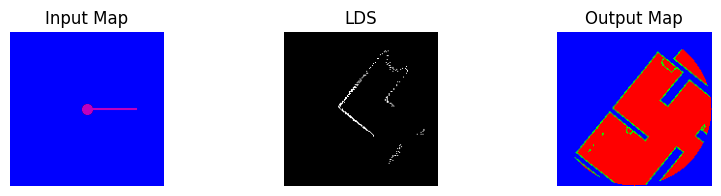

input_map:  (159, 159, 3)
lds_map:    (159, 159)
output_map: (159, 159, 3)
adlo:       [ 1.          0.06650611 -0.1320825  -0.31531525]
metadata:   [2.0000000e+00 2.0000000e+00 1.2393085e+04 1.5160209e+03 0.0000000e+00
 1.2865870e+04 5.7706079e+02 2.2837534e+00]


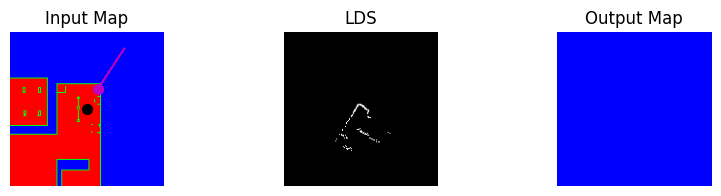

In [ ]:
slam_data.show_dataset(train_data, num=2)

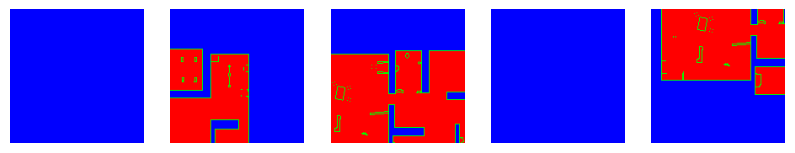

NameError: name 'revisor' is not defined

In [ ]:
def show_input_maps(dataset, num=5):
    plt.figure(figsize=(10, 2))
    if dataset.element_spec[0][0].shape.ndims <= 3:
      dataset = dataset.batch(num)
    for entry in dataset.take(1):
      input_map = entry[0][0]
      for i in range(num):
        plt.subplot(1, num, i+1)
        plt.imshow(input_map[i])
        plt.axis('off')
    plt.show()

show_input_maps(train_data)

model_train_data = train_data.map(revisor.map).map(slam_data.for_model_training)\
  .shuffle(buffer_size=len(train_data))\
  .batch(32)\
  .prefetch(tf.data.experimental.AUTOTUNE)

show_input_maps(model_train_data)

In [ ]:
def display_history(model_history):
    """
    Flexibly supports different losses and metrics.
    Applies some heuristics to group the losses together onto a log plot, and the other metrics
    on a linear plot.

    Implementation note:
    While `model_history.epoch` is available and contains a list of epoch numbers,
    I can't use it with aggregated history because it'll only include the values
    from the most recent run.
    :param model_history:
    """

    # identify "losses" vs other metrics
    loss_keys = [k for k in model_history.history.keys() if 'loss' in k or 'entropy' in k]
    metric_keys = [k for k in model_history.history.keys() if 'loss' not in k and 'entropy' not in k]

    plt.figure(figsize=(11, 3))
    if len(loss_keys) > 0:
        plt.subplot(1, 2, 1)
        plt.title("Loss")
        for key in loss_keys:
            plt.plot(model_history.history[key], label=key)
        plt.legend()
        plt.yscale('log')
        plt.xlabel('Epoch')

    if len(metric_keys) > 0:
        plt.subplot(1, 2, 2)
        plt.title("Metrics")
        for key in metric_keys:
            plt.plot(model_history.history[key], label=key)
        plt.legend()
        plt.xlabel('Epoch')

    plt.show()

In [ ]:
def show_revised_predictions(model, dataset, num=5, **kwargs):
  tf.random.set_seed(0)  # for better chance of comparing things
  revisor = slam_data.DatasetRevisor(floorplan, model)
  revisor.prepare()
  test_data = dataset.map(revisor.map)
  slam_data.show_predictions(model, test_data, num, **kwargs)

map_shape: (159, 159, 3)
Added final cropping layer: w=1, h=1
Prepared SLAM model
  Map shape:        (159, 159, 3) + padding (1, 1, 0)
  Skip-connections: concat
  Output scaling:   logits
  DLO encoding:     linear/importance
  Inputs:           [<KerasTensor shape=(None, 159, 159, 3), dtype=float32, sparse=None, name=map_input>, <KerasTensor shape=(None, 159, 159), dtype=float32, sparse=None, name=lds_input>]
  Outputs:          [<KerasTensor shape=(None, 159, 159, 3), dtype=float32, sparse=False, name=keras_tensor_51>, <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_57>]
  Compiled:         True
Epochs 0 to 4 with inputs like:


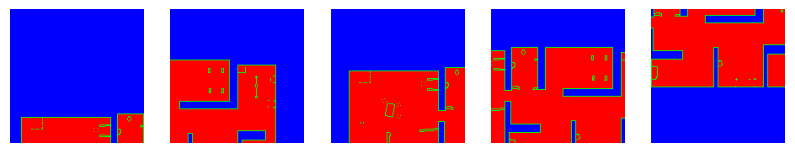

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 77s 981ms/step - adlo_output_accept_accuracy: 0.6210 - adlo_output_adlo_loss: 7.0599 - adlo_output_loc_error: 0.2607 - adlo_output_orientation_error: 1.7731 - loss: 7.9023 - map_output_map_accuracy: 0.5996 - map_output_map_loss: 0.8403 - map_output_obstruction_accuracy: 0.0059
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 359ms/step - adlo_output_accept_accuracy: 0.7237 - adlo_output_adlo_loss: 1.2625 - adlo_output_loc_error: 0.1045 - adlo_output_orientation_error: 0.1867 - loss: 1.9336 - map_output_map_accuracy: 0.6881 - map_output_map_loss: 0.6708 - map_output_obstruction_accuracy: 4.0801e-04
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 363ms/step - adlo_output_accept_accuracy: 0.7429 - adlo_output_adlo_loss: 1.2347 - adlo_output_loc_error: 0.1032 - adlo_output_orientation_error: 0.1833 - loss: 1.8252 - map_output_map_accuracy: 0.7365 - map_output_map_loss: 0.5906 - map_output_obstruction_accuracy: 0.0053
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step

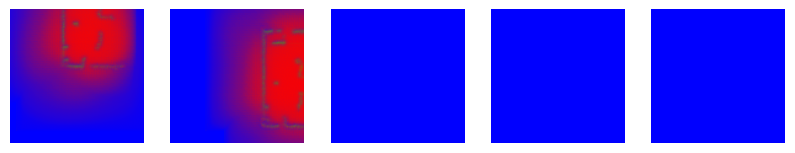

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 590ms/step - adlo_output_accept_accuracy: 0.7516 - adlo_output_adlo_loss: 1.1939 - adlo_output_loc_error: 0.1140 - adlo_output_orientation_error: 0.1985 - loss: 1.8217 - map_output_map_accuracy: 0.7264 - map_output_map_loss: 0.6284 - map_output_obstruction_accuracy: 9.8199e-04
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 366ms/step - adlo_output_accept_accuracy: 0.7490 - adlo_output_adlo_loss: 1.1915 - adlo_output_loc_error: 0.1108 - adlo_output_orientation_error: 0.2000 - loss: 1.7753 - map_output_map_accuracy: 0.7477 - map_output_map_loss: 0.5837 - map_output_obstruction_accuracy: 0.0016
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 369ms/step - adlo_output_accept_accuracy: 0.7393 - adlo_output_adlo_loss: 1.1693 - adlo_output_loc_error: 0.1098 - adlo_output_orientation_error: 0.1915 - loss: 1.7301 - map_output_map_accuracy: 0.7611 - map_output_map_loss: 0.5604 - map_output_obstruction_accuracy: 0.0031
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 371ms/step

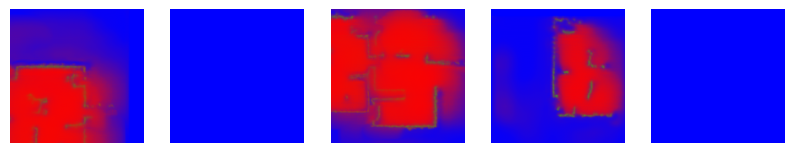

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 372ms/step - adlo_output_accept_accuracy: 0.7396 - adlo_output_adlo_loss: 1.1783 - adlo_output_loc_error: 0.1067 - adlo_output_orientation_error: 0.1909 - loss: 1.6926 - map_output_map_accuracy: 0.7870 - map_output_map_loss: 0.5139 - map_output_obstruction_accuracy: 0.0140
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 374ms/step - adlo_output_accept_accuracy: 0.7419 - adlo_output_adlo_loss: 1.1813 - adlo_output_loc_error: 0.1091 - adlo_output_orientation_error: 0.1935 - loss: 1.7064 - map_output_map_accuracy: 0.7820 - map_output_map_loss: 0.5257 - map_output_obstruction_accuracy: 0.0196
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 374ms/step - adlo_output_accept_accuracy: 0.7084 - adlo_output_adlo_loss: 1.1990 - adlo_output_loc_error: 0.1015 - adlo_output_orientation_error: 0.1895 - loss: 1.7042 - map_output_map_accuracy: 0.7941 - map_output_map_loss: 0.5054 - map_output_obstruction_accuracy: 0.0163
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 375ms/step - a

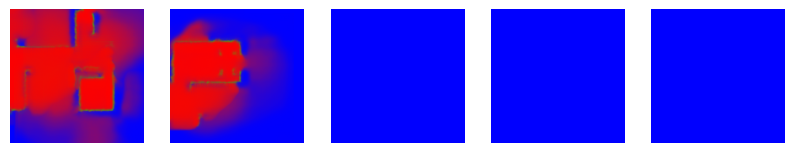

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 374ms/step - adlo_output_accept_accuracy: 0.7728 - adlo_output_adlo_loss: 1.1179 - adlo_output_loc_error: 0.1079 - adlo_output_orientation_error: 0.1799 - loss: 1.5773 - map_output_map_accuracy: 0.8140 - map_output_map_loss: 0.4588 - map_output_obstruction_accuracy: 0.0226
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 375ms/step - adlo_output_accept_accuracy: 0.7351 - adlo_output_adlo_loss: 1.1477 - adlo_output_loc_error: 0.1126 - adlo_output_orientation_error: 0.1940 - loss: 1.5939 - map_output_map_accuracy: 0.8223 - map_output_map_loss: 0.4467 - map_output_obstruction_accuracy: 0.0232
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 376ms/step - adlo_output_accept_accuracy: 0.7051 - adlo_output_adlo_loss: 1.1438 - adlo_output_loc_error: 0.1042 - adlo_output_orientation_error: 0.1807 - loss: 1.5874 - map_output_map_accuracy: 0.8239 - map_output_map_loss: 0.4424 - map_output_obstruction_accuracy: 0.0238
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 376ms/step - a

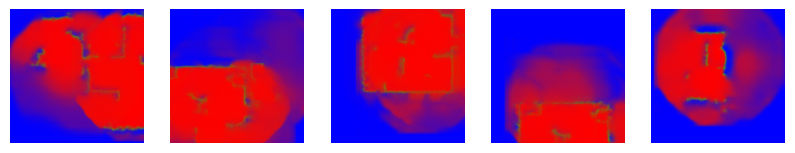

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 375ms/step - adlo_output_accept_accuracy: 0.7411 - adlo_output_adlo_loss: 1.0762 - adlo_output_loc_error: 0.1093 - adlo_output_orientation_error: 0.1920 - loss: 1.4643 - map_output_map_accuracy: 0.8489 - map_output_map_loss: 0.3878 - map_output_obstruction_accuracy: 0.0505
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 375ms/step - adlo_output_accept_accuracy: 0.7359 - adlo_output_adlo_loss: 1.0367 - adlo_output_loc_error: 0.1089 - adlo_output_orientation_error: 0.1933 - loss: 1.4608 - map_output_map_accuracy: 0.8331 - map_output_map_loss: 0.4244 - map_output_obstruction_accuracy: 0.0482
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 376ms/step - adlo_output_accept_accuracy: 0.7229 - adlo_output_adlo_loss: 1.0071 - adlo_output_loc_error: 0.1089 - adlo_output_orientation_error: 0.1719 - loss: 1.4053 - map_output_map_accuracy: 0.8428 - map_output_map_loss: 0.3989 - map_output_obstruction_accuracy: 0.0563
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 376ms/step - a

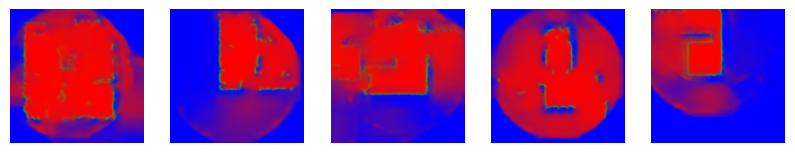

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 374ms/step - adlo_output_accept_accuracy: 0.8347 - adlo_output_adlo_loss: 0.9042 - adlo_output_loc_error: 0.1084 - adlo_output_orientation_error: 0.1711 - loss: 1.3076 - map_output_map_accuracy: 0.8390 - map_output_map_loss: 0.4041 - map_output_obstruction_accuracy: 0.0623
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 376ms/step - adlo_output_accept_accuracy: 0.8596 - adlo_output_adlo_loss: 0.8764 - adlo_output_loc_error: 0.0993 - adlo_output_orientation_error: 0.1656 - loss: 1.2816 - map_output_map_accuracy: 0.8390 - map_output_map_loss: 0.4047 - map_output_obstruction_accuracy: 0.0610
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 376ms/step - adlo_output_accept_accuracy: 0.8935 - adlo_output_adlo_loss: 0.8428 - adlo_output_loc_error: 0.1062 - adlo_output_orientation_error: 0.1764 - loss: 1.2221 - map_output_map_accuracy: 0.8518 - map_output_map_loss: 0.3789 - map_output_obstruction_accuracy: 0.0703
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 376ms/step - a

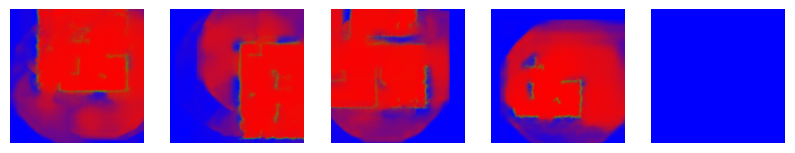

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 376ms/step - adlo_output_accept_accuracy: 0.8777 - adlo_output_adlo_loss: 0.8713 - adlo_output_loc_error: 0.1123 - adlo_output_orientation_error: 0.1946 - loss: 1.2990 - map_output_map_accuracy: 0.8306 - map_output_map_loss: 0.4280 - map_output_obstruction_accuracy: 0.0374
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 376ms/step - adlo_output_accept_accuracy: 0.8782 - adlo_output_adlo_loss: 0.8397 - adlo_output_loc_error: 0.1056 - adlo_output_orientation_error: 0.1841 - loss: 1.2545 - map_output_map_accuracy: 0.8352 - map_output_map_loss: 0.4159 - map_output_obstruction_accuracy: 0.0462
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 376ms/step - adlo_output_accept_accuracy: 0.9237 - adlo_output_adlo_loss: 0.7961 - adlo_output_loc_error: 0.1139 - adlo_output_orientation_error: 0.1879 - loss: 1.1799 - map_output_map_accuracy: 0.8485 - map_output_map_loss: 0.3837 - map_output_obstruction_accuracy: 0.0568
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 376ms/step - a

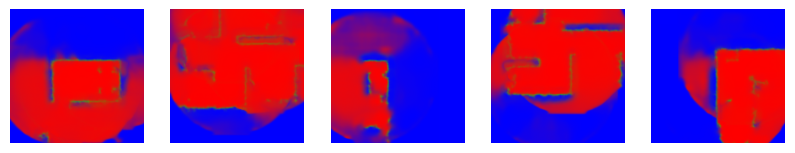

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 375ms/step - adlo_output_accept_accuracy: 0.9739 - adlo_output_adlo_loss: 0.6826 - adlo_output_loc_error: 0.1081 - adlo_output_orientation_error: 0.1725 - loss: 1.0336 - map_output_map_accuracy: 0.8641 - map_output_map_loss: 0.3511 - map_output_obstruction_accuracy: 0.0650
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 376ms/step - adlo_output_accept_accuracy: 0.9153 - adlo_output_adlo_loss: 0.7853 - adlo_output_loc_error: 0.1040 - adlo_output_orientation_error: 0.1844 - loss: 1.1814 - map_output_map_accuracy: 0.8469 - map_output_map_loss: 0.3952 - map_output_obstruction_accuracy: 0.0370
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 376ms/step - adlo_output_accept_accuracy: 0.9717 - adlo_output_adlo_loss: 0.6206 - adlo_output_loc_error: 0.0981 - adlo_output_orientation_error: 0.1698 - loss: 0.9910 - map_output_map_accuracy: 0.8558 - map_output_map_loss: 0.3706 - map_output_obstruction_accuracy: 0.0640
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 376ms/step - a

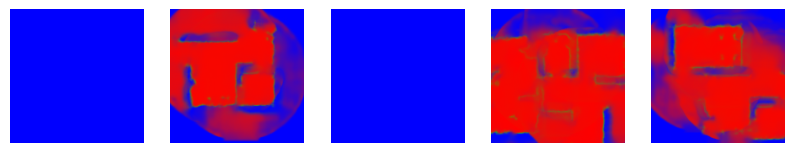

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 375ms/step - adlo_output_accept_accuracy: 0.9810 - adlo_output_adlo_loss: 0.6401 - adlo_output_loc_error: 0.1026 - adlo_output_orientation_error: 0.1839 - loss: 0.9658 - map_output_map_accuracy: 0.8767 - map_output_map_loss: 0.3261 - map_output_obstruction_accuracy: 0.0778
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 376ms/step - adlo_output_accept_accuracy: 0.9793 - adlo_output_adlo_loss: 0.6089 - adlo_output_loc_error: 0.1013 - adlo_output_orientation_error: 0.1720 - loss: 0.9438 - map_output_map_accuracy: 0.8727 - map_output_map_loss: 0.3350 - map_output_obstruction_accuracy: 0.0821
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 376ms/step - adlo_output_accept_accuracy: 0.9828 - adlo_output_adlo_loss: 0.6235 - adlo_output_loc_error: 0.1053 - adlo_output_orientation_error: 0.1880 - loss: 0.9686 - map_output_map_accuracy: 0.8687 - map_output_map_loss: 0.3448 - map_output_obstruction_accuracy: 0.0743
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 376ms/step - a

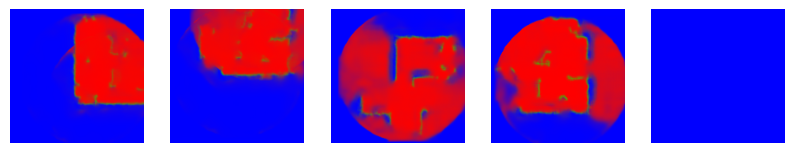

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 374ms/step - adlo_output_accept_accuracy: 0.9180 - adlo_output_adlo_loss: 0.8600 - adlo_output_loc_error: 0.1061 - adlo_output_orientation_error: 0.1758 - loss: 1.2608 - map_output_map_accuracy: 0.8433 - map_output_map_loss: 0.4004 - map_output_obstruction_accuracy: 0.0778
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 375ms/step - adlo_output_accept_accuracy: 0.9736 - adlo_output_adlo_loss: 0.6546 - adlo_output_loc_error: 0.1042 - adlo_output_orientation_error: 0.1873 - loss: 1.0089 - map_output_map_accuracy: 0.8624 - map_output_map_loss: 0.3550 - map_output_obstruction_accuracy: 0.0698
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 376ms/step - adlo_output_accept_accuracy: 0.9819 - adlo_output_adlo_loss: 0.6134 - adlo_output_loc_error: 0.0996 - adlo_output_orientation_error: 0.1807 - loss: 0.9339 - map_output_map_accuracy: 0.8771 - map_output_map_loss: 0.3208 - map_output_obstruction_accuracy: 0.0830
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 375ms/step - a

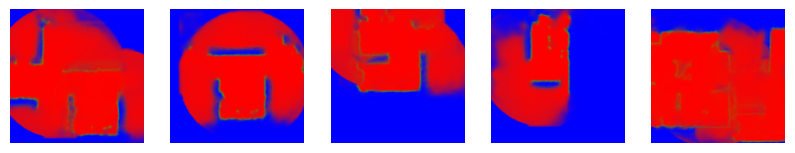

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 375ms/step - adlo_output_accept_accuracy: 0.9919 - adlo_output_adlo_loss: 0.5749 - adlo_output_loc_error: 0.0982 - adlo_output_orientation_error: 0.1799 - loss: 0.8575 - map_output_map_accuracy: 0.8964 - map_output_map_loss: 0.2824 - map_output_obstruction_accuracy: 0.0961
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 375ms/step - adlo_output_accept_accuracy: 0.9871 - adlo_output_adlo_loss: 0.5601 - adlo_output_loc_error: 0.0973 - adlo_output_orientation_error: 0.1762 - loss: 0.8385 - map_output_map_accuracy: 0.8985 - map_output_map_loss: 0.2785 - map_output_obstruction_accuracy: 0.0964
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 375ms/step - adlo_output_accept_accuracy: 0.9966 - adlo_output_adlo_loss: 0.5368 - adlo_output_loc_error: 0.0933 - adlo_output_orientation_error: 0.1730 - loss: 0.8096 - map_output_map_accuracy: 0.9007 - map_output_map_loss: 0.2731 - map_output_obstruction_accuracy: 0.0996
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 376ms/step - a

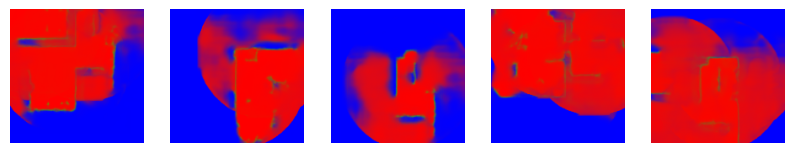

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 375ms/step - adlo_output_accept_accuracy: 0.9901 - adlo_output_adlo_loss: 0.5209 - adlo_output_loc_error: 0.0886 - adlo_output_orientation_error: 0.1663 - loss: 0.8036 - map_output_map_accuracy: 0.8967 - map_output_map_loss: 0.2829 - map_output_obstruction_accuracy: 0.1024
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 376ms/step - adlo_output_accept_accuracy: 0.9764 - adlo_output_adlo_loss: 0.5824 - adlo_output_loc_error: 0.0934 - adlo_output_orientation_error: 0.1673 - loss: 0.9251 - map_output_map_accuracy: 0.8732 - map_output_map_loss: 0.3427 - map_output_obstruction_accuracy: 0.0997
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 376ms/step - adlo_output_accept_accuracy: 0.9776 - adlo_output_adlo_loss: 0.5854 - adlo_output_loc_error: 0.0969 - adlo_output_orientation_error: 0.1676 - loss: 0.9091 - map_output_map_accuracy: 0.8803 - map_output_map_loss: 0.3238 - map_output_obstruction_accuracy: 0.0962
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 375ms/step - a

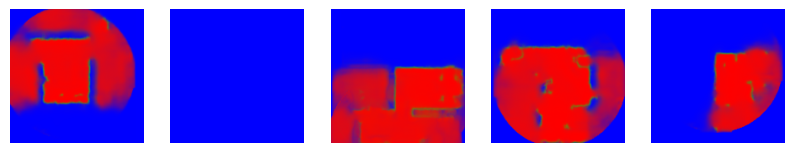

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 376ms/step - adlo_output_accept_accuracy: 0.9905 - adlo_output_adlo_loss: 0.5379 - adlo_output_loc_error: 0.0888 - adlo_output_orientation_error: 0.1560 - loss: 0.8458 - map_output_map_accuracy: 0.8842 - map_output_map_loss: 0.3079 - map_output_obstruction_accuracy: 0.1131
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 376ms/step - adlo_output_accept_accuracy: 0.9994 - adlo_output_adlo_loss: 0.4691 - adlo_output_loc_error: 0.0827 - adlo_output_orientation_error: 0.1472 - loss: 0.7410 - map_output_map_accuracy: 0.9009 - map_output_map_loss: 0.2718 - map_output_obstruction_accuracy: 0.1235
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 376ms/step - adlo_output_accept_accuracy: 0.9987 - adlo_output_adlo_loss: 0.4363 - adlo_output_loc_error: 0.0819 - adlo_output_orientation_error: 0.1349 - loss: 0.6832 - map_output_map_accuracy: 0.9103 - map_output_map_loss: 0.2470 - map_output_obstruction_accuracy: 0.1303
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 376ms/step - a

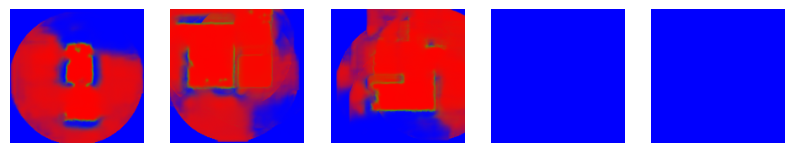

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 375ms/step - adlo_output_accept_accuracy: 0.9934 - adlo_output_adlo_loss: 0.4279 - adlo_output_loc_error: 0.0733 - adlo_output_orientation_error: 0.1331 - loss: 0.6732 - map_output_map_accuracy: 0.9135 - map_output_map_loss: 0.2449 - map_output_obstruction_accuracy: 0.1185
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 376ms/step - adlo_output_accept_accuracy: 0.9987 - adlo_output_adlo_loss: 0.3870 - adlo_output_loc_error: 0.0705 - adlo_output_orientation_error: 0.1194 - loss: 0.6121 - map_output_map_accuracy: 0.9204 - map_output_map_loss: 0.2247 - map_output_obstruction_accuracy: 0.1300
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 376ms/step - adlo_output_accept_accuracy: 1.0000 - adlo_output_adlo_loss: 0.3837 - adlo_output_loc_error: 0.0711 - adlo_output_orientation_error: 0.1212 - loss: 0.6024 - map_output_map_accuracy: 0.9232 - map_output_map_loss: 0.2186 - map_output_obstruction_accuracy: 0.1350
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 376ms/step - a

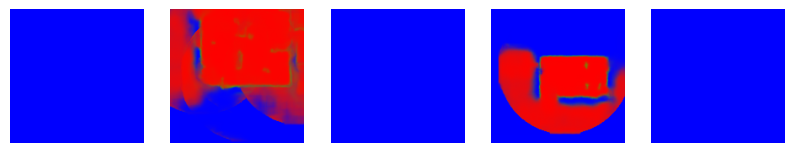

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 376ms/step - adlo_output_accept_accuracy: 0.9982 - adlo_output_adlo_loss: 0.3602 - adlo_output_loc_error: 0.0676 - adlo_output_orientation_error: 0.1096 - loss: 0.5817 - map_output_map_accuracy: 0.9218 - map_output_map_loss: 0.2214 - map_output_obstruction_accuracy: 0.1237
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 376ms/step - adlo_output_accept_accuracy: 0.9971 - adlo_output_adlo_loss: 0.3927 - adlo_output_loc_error: 0.0706 - adlo_output_orientation_error: 0.1156 - loss: 0.6212 - map_output_map_accuracy: 0.9198 - map_output_map_loss: 0.2280 - map_output_obstruction_accuracy: 0.1185
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 376ms/step - adlo_output_accept_accuracy: 1.0000 - adlo_output_adlo_loss: 0.3252 - adlo_output_loc_error: 0.0606 - adlo_output_orientation_error: 0.0937 - loss: 0.5371 - map_output_map_accuracy: 0.9257 - map_output_map_loss: 0.2117 - map_output_obstruction_accuracy: 0.1272
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 376ms/step - a

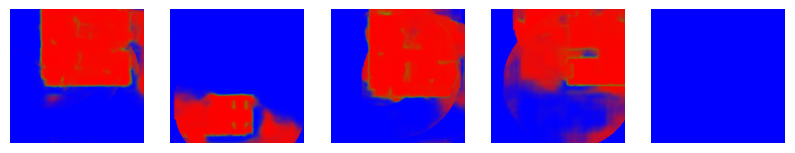

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 376ms/step - adlo_output_accept_accuracy: 0.9990 - adlo_output_adlo_loss: 0.3237 - adlo_output_loc_error: 0.0599 - adlo_output_orientation_error: 0.0881 - loss: 0.5166 - map_output_map_accuracy: 0.9330 - map_output_map_loss: 0.1933 - map_output_obstruction_accuracy: 0.1354
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 376ms/step - adlo_output_accept_accuracy: 0.9984 - adlo_output_adlo_loss: 0.3178 - adlo_output_loc_error: 0.0557 - adlo_output_orientation_error: 0.0972 - loss: 0.5191 - map_output_map_accuracy: 0.9293 - map_output_map_loss: 0.2009 - map_output_obstruction_accuracy: 0.1368
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 375ms/step - adlo_output_accept_accuracy: 0.9997 - adlo_output_adlo_loss: 0.2995 - adlo_output_loc_error: 0.0517 - adlo_output_orientation_error: 0.0874 - loss: 0.4925 - map_output_map_accuracy: 0.9332 - map_output_map_loss: 0.1928 - map_output_obstruction_accuracy: 0.1458
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 376ms/step - a

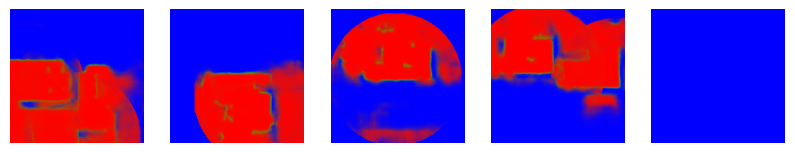

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 375ms/step - adlo_output_accept_accuracy: 0.9976 - adlo_output_adlo_loss: 0.2744 - adlo_output_loc_error: 0.0521 - adlo_output_orientation_error: 0.0780 - loss: 0.4605 - map_output_map_accuracy: 0.9346 - map_output_map_loss: 0.1862 - map_output_obstruction_accuracy: 0.1515
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 375ms/step - adlo_output_accept_accuracy: 1.0000 - adlo_output_adlo_loss: 0.2914 - adlo_output_loc_error: 0.0516 - adlo_output_orientation_error: 0.0845 - loss: 0.4924 - map_output_map_accuracy: 0.9301 - map_output_map_loss: 0.2008 - map_output_obstruction_accuracy: 0.1397
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 375ms/step - adlo_output_accept_accuracy: 1.0000 - adlo_output_adlo_loss: 0.2625 - adlo_output_loc_error: 0.0494 - adlo_output_orientation_error: 0.0734 - loss: 0.4471 - map_output_map_accuracy: 0.9351 - map_output_map_loss: 0.1848 - map_output_obstruction_accuracy: 0.1429
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 376ms/step - a

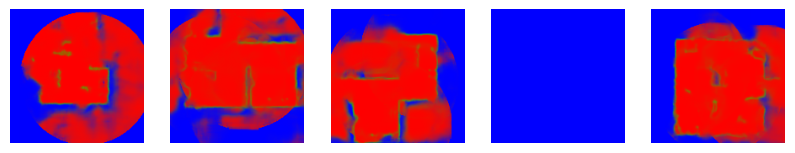

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 376ms/step - adlo_output_accept_accuracy: 0.9989 - adlo_output_adlo_loss: 0.2455 - adlo_output_loc_error: 0.0441 - adlo_output_orientation_error: 0.0692 - loss: 0.4312 - map_output_map_accuracy: 0.9349 - map_output_map_loss: 0.1856 - map_output_obstruction_accuracy: 0.1492
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 376ms/step - adlo_output_accept_accuracy: 0.9986 - adlo_output_adlo_loss: 0.2443 - adlo_output_loc_error: 0.0448 - adlo_output_orientation_error: 0.0648 - loss: 0.4256 - map_output_map_accuracy: 0.9368 - map_output_map_loss: 0.1813 - map_output_obstruction_accuracy: 0.1479
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 376ms/step - adlo_output_accept_accuracy: 1.0000 - adlo_output_adlo_loss: 0.2293 - adlo_output_loc_error: 0.0408 - adlo_output_orientation_error: 0.0648 - loss: 0.3998 - map_output_map_accuracy: 0.9401 - map_output_map_loss: 0.1703 - map_output_obstruction_accuracy: 0.1581
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 376ms/step - a

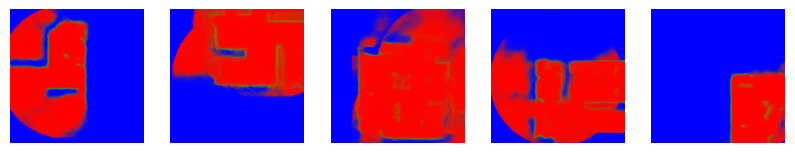

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 376ms/step - adlo_output_accept_accuracy: 1.0000 - adlo_output_adlo_loss: 0.2195 - adlo_output_loc_error: 0.0384 - adlo_output_orientation_error: 0.0633 - loss: 0.3906 - map_output_map_accuracy: 0.9402 - map_output_map_loss: 0.1711 - map_output_obstruction_accuracy: 0.1426
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 376ms/step - adlo_output_accept_accuracy: 1.0000 - adlo_output_adlo_loss: 0.2181 - adlo_output_loc_error: 0.0394 - adlo_output_orientation_error: 0.0619 - loss: 0.3816 - map_output_map_accuracy: 0.9426 - map_output_map_loss: 0.1635 - map_output_obstruction_accuracy: 0.1489
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 377ms/step - adlo_output_accept_accuracy: 1.0000 - adlo_output_adlo_loss: 0.1869 - adlo_output_loc_error: 0.0339 - adlo_output_orientation_error: 0.0507 - loss: 0.3452 - map_output_map_accuracy: 0.9442 - map_output_map_loss: 0.1584 - map_output_obstruction_accuracy: 0.1571
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 376ms/step - a

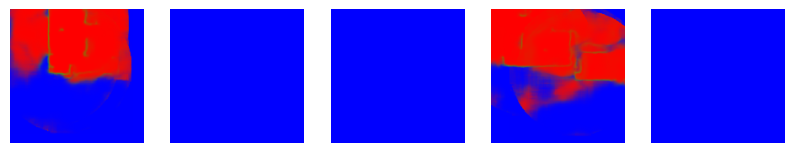

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 376ms/step - adlo_output_accept_accuracy: 0.9991 - adlo_output_adlo_loss: 0.2157 - adlo_output_loc_error: 0.0387 - adlo_output_orientation_error: 0.0556 - loss: 0.4039 - map_output_map_accuracy: 0.9338 - map_output_map_loss: 0.1880 - map_output_obstruction_accuracy: 0.1451
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 376ms/step - adlo_output_accept_accuracy: 1.0000 - adlo_output_adlo_loss: 0.2312 - adlo_output_loc_error: 0.0394 - adlo_output_orientation_error: 0.0688 - loss: 0.4058 - map_output_map_accuracy: 0.9389 - map_output_map_loss: 0.1744 - map_output_obstruction_accuracy: 0.1556
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 375ms/step - adlo_output_accept_accuracy: 1.0000 - adlo_output_adlo_loss: 0.1920 - adlo_output_loc_error: 0.0333 - adlo_output_orientation_error: 0.0515 - loss: 0.3551 - map_output_map_accuracy: 0.9427 - map_output_map_loss: 0.1633 - map_output_obstruction_accuracy: 0.1700
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 376ms/step - a

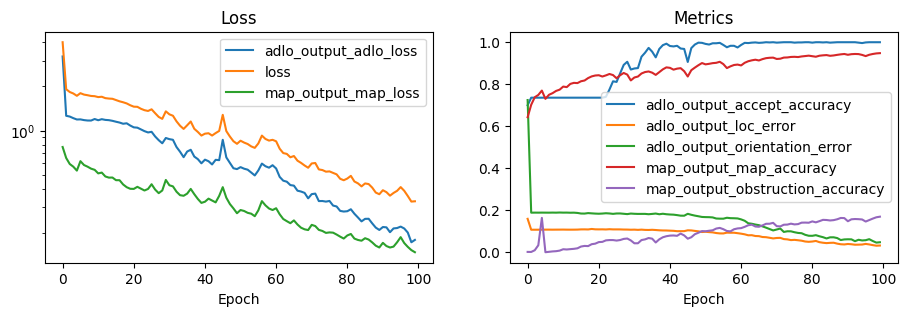

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 6.3306079e+00 -7.7241834e-04 -6.9954165e-04 -1.5053089e-03]
adlo-pred scaled: [ 9.9822217e-01 -7.7241834e-04 -6.9954165e-04 -1.5053089e-03]
metadata:         [2.0000000e+00 0.0000000e+00           nan           nan           nan
 7.7704326e+03 5.2244917e+03 2.2490387e+00]


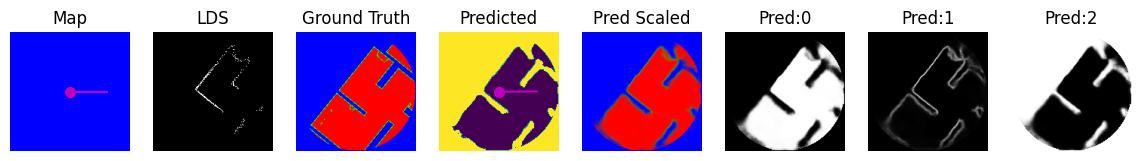

adlo:             [ 1.          0.06650611 -0.1320825  -0.31531525]
adlo-pred raw:    [ 9.547361    0.06964566 -0.12316626 -0.23888263]
adlo-pred scaled: [ 0.9999286   0.06964566 -0.12316626 -0.23888263]
metadata:         [2.0000000e+00 2.0000000e+00 1.2393085e+04 1.5160209e+03 0.0000000e+00
 1.2865870e+04 5.7706079e+02 2.2837534e+00]


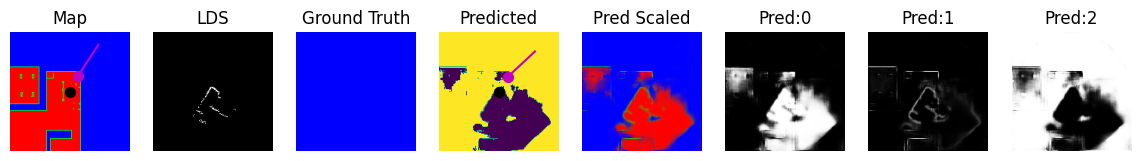

adlo:             [ 1.          0.08753846  0.48659375 -0.07261062]
adlo-pred raw:    [12.206472    0.21789953  0.56009865 -0.10710206]
adlo-pred scaled: [ 0.999995    0.21789953  0.56009865 -0.10710206]
metadata:         [2.0000000e+00 2.0000000e+00 5.3261099e+03 1.4369366e+03 0.0000000e+00
 5.9484111e+03 4.8960781e+03 1.1705631e+00]


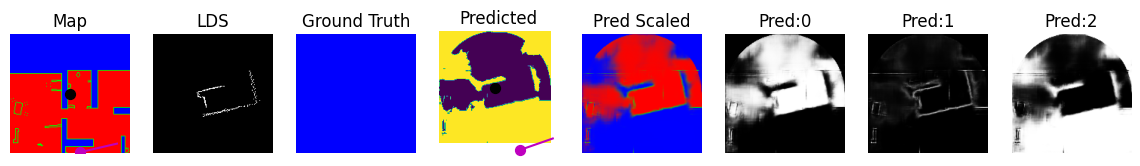

adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 5.2157536e+00 -1.1932364e-03 -3.0997687e-04 -4.3580227e-04]
adlo-pred scaled: [ 9.9459898e-01 -1.1932364e-03 -3.0997687e-04 -4.3580227e-04]
metadata:         [2.0000000e+00 0.0000000e+00           nan           nan           nan
 1.1377892e+04 1.6338907e+03 2.9138200e+00]


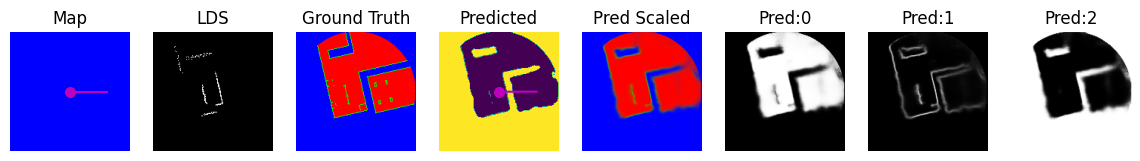

adlo:             [ 1.         -0.04257149 -0.08866958  0.0635903 ]
adlo-pred raw:    [ 9.3264885  -0.03462698 -0.06967689  0.07543639]
adlo-pred scaled: [ 0.99991095 -0.03462698 -0.06967689  0.07543639]
metadata:         [ 2.0000000e+00  1.0000000e+00  3.1065562e+03  5.0983755e+03
  0.0000000e+00  2.8039202e+03  4.4680332e+03 -4.6301708e-01]


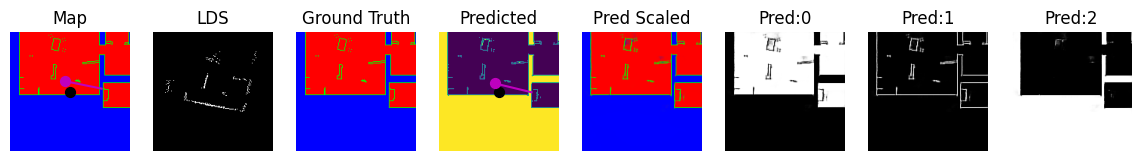

adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 6.0086989e+00 -2.6900120e-04 -1.2132908e-03 -3.7174404e-04]
adlo-pred scaled: [ 9.9754876e-01 -2.6900120e-04 -1.2132908e-03 -3.7174404e-04]
metadata:         [ 2.0000000e+00  0.0000000e+00            nan            nan
            nan  9.1949268e+03  1.1775712e+03 -1.0998367e+00]


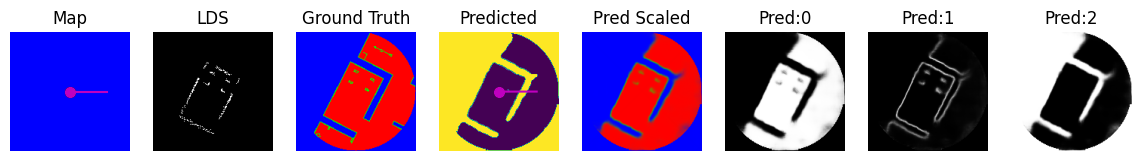

adlo:             [ 1.0000000e+00 -4.5766373e-04  2.0432066e-02  4.3668937e-02]
adlo-pred raw:    [ 9.29231834e+00 -1.44055707e-03  1.03464145e-02  4.95294668e-02]
adlo-pred scaled: [ 0.99990785 -0.00144056  0.01034641  0.04952947]
metadata:         [ 2.0000000e+00  1.0000000e+00  1.1190451e+04  2.4545078e+03
  0.0000000e+00  1.1187198e+04  2.5997571e+03 -5.7919192e-01]


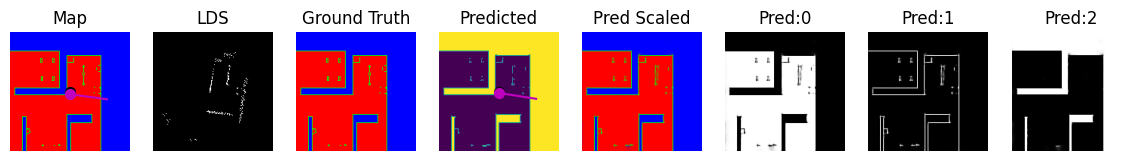

adlo:             [ 1.         -0.02623202 -0.06905483  0.02933878]
adlo-pred raw:    [ 7.912321   -0.02216076 -0.05716665  0.04845653]
adlo-pred scaled: [ 0.9996339  -0.02216076 -0.05716665  0.04845653]
metadata:         [2.0000000e+00 1.0000000e+00 9.9319688e+03 6.1553672e+03 0.0000000e+00
 9.7454883e+03 5.6644639e+03 5.9592706e-01]


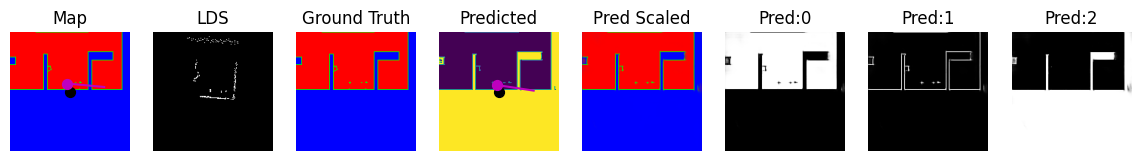

In [ ]:
reload(slam)
reload(slam_data)

one = next(iter(train_data))
map_shape = one[0][0].shape
print(f"map_shape: {map_shape}")
np.random.seed(42)
tf.random.set_seed(42)

epochs = 100
batch_size = 32
dataset_revision_period = 5

model = slam.slam_model(map_shape, compile=True, verbose_history=True)
model_train_data = train_data.map(slam_data.for_model_training)\
  .shuffle(buffer_size=len(train_data))\
  .batch(batch_size)\
  .prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
agg_history = tf.keras.callbacks.History()
for i in range(0, math.ceil(epochs/dataset_revision_period) * dataset_revision_period, dataset_revision_period):
  if i > 0:
    revisor = slam_data.DatasetRevisor(floorplan, model)
    revisor.prepare()
    model_train_data = train_data.map(revisor.map).map(slam_data.for_model_training)\
      .shuffle(buffer_size=len(train_data))\
      .batch(batch_size)\
      .prefetch(tf.data.experimental.AUTOTUNE)
  print(f"Epochs {i} to {i+dataset_revision_period-1} with inputs like:")
  show_input_maps(model_train_data)
  model_history = model.fit(model_train_data, epochs=dataset_revision_period, callbacks=[agg_history])
duration = (timer() - start)

print(f"Epochs: {epochs}, duration: {duration} sec")
display_history(model_history)
slam_data.show_predictions(model, train_data, 8, show_classes='pred')

Generating 80 LDS maps...
Generating semantic maps...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 6.3306079e+00 -7.7241834e-04 -6.9954165e-04 -1.5053089e-03]
adlo-pred scaled: [ 9.9822217e-01 -7.7241834e-04 -6.9954165e-04 -1.5053089e-03]
metadata:         [2.0000000e+00 0.0000000e+00           nan           nan           nan
 7.7704326e+03 5.2244917e+03 2.2490387e+00]


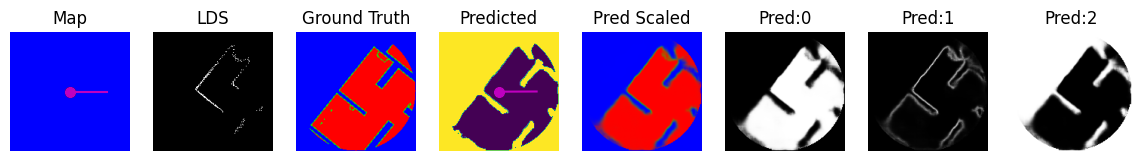

adlo:             [ 1.          0.06650611 -0.1320825  -0.31531525]
adlo-pred raw:    [11.3677225   0.07509271 -0.1059605  -0.24366358]
adlo-pred scaled: [ 0.99998844  0.07509271 -0.1059605  -0.24366358]
metadata:         [2.0000000e+00 2.0000000e+00 1.2393085e+04 1.5160209e+03 0.0000000e+00
 1.2865870e+04 5.7706079e+02 2.2837534e+00]


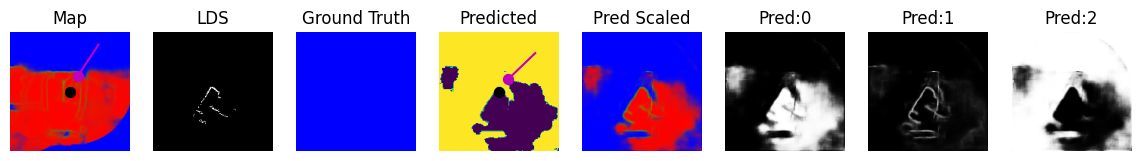

adlo:             [ 1.          0.08753846  0.48659375 -0.07261062]
adlo-pred raw:    [11.367062    0.13158348  0.4529311  -0.05828194]
adlo-pred scaled: [ 0.99998844  0.13158348  0.4529311  -0.05828194]
metadata:         [2.0000000e+00 2.0000000e+00 5.3261099e+03 1.4369366e+03 0.0000000e+00
 5.9484111e+03 4.8960781e+03 1.1705631e+00]


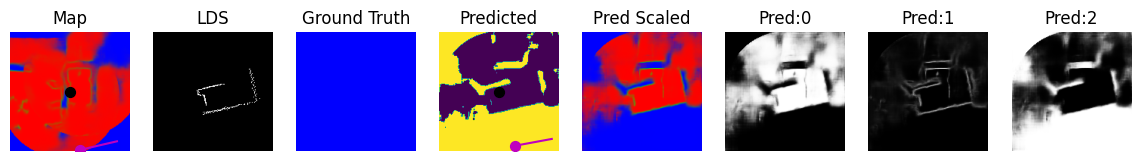

adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 5.2157536e+00 -1.1932364e-03 -3.0997687e-04 -4.3580227e-04]
adlo-pred scaled: [ 9.9459898e-01 -1.1932364e-03 -3.0997687e-04 -4.3580227e-04]
metadata:         [2.0000000e+00 0.0000000e+00           nan           nan           nan
 1.1377892e+04 1.6338907e+03 2.9138200e+00]


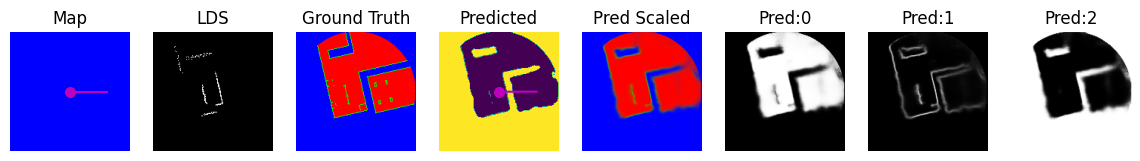

adlo:             [ 1.         -0.04257149 -0.08866958  0.0635903 ]
adlo-pred raw:    [ 8.740506   -0.03870009 -0.04232117  0.05622737]
adlo-pred scaled: [ 0.99984    -0.03870009 -0.04232117  0.05622737]
metadata:         [ 2.0000000e+00  1.0000000e+00  3.1065562e+03  5.0983755e+03
  0.0000000e+00  2.8039202e+03  4.4680332e+03 -4.6301708e-01]


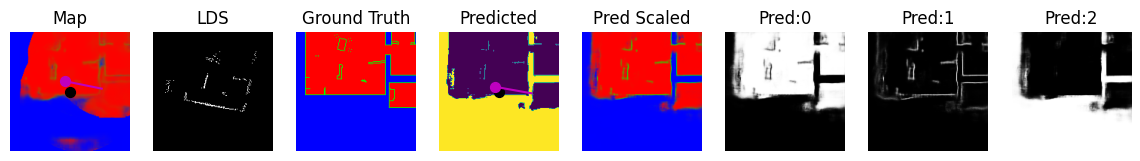

adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 6.0086989e+00 -2.6900120e-04 -1.2132908e-03 -3.7174404e-04]
adlo-pred scaled: [ 9.9754876e-01 -2.6900120e-04 -1.2132908e-03 -3.7174404e-04]
metadata:         [ 2.0000000e+00  0.0000000e+00            nan            nan
            nan  9.1949268e+03  1.1775712e+03 -1.0998367e+00]


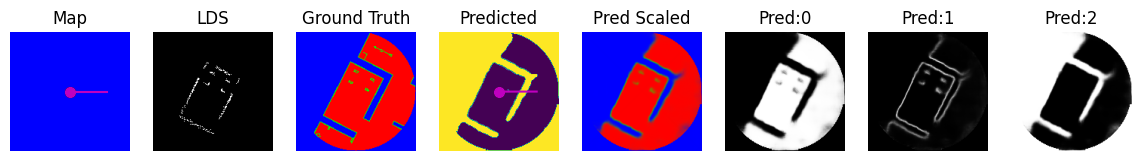

adlo:             [ 1.0000000e+00 -4.5766373e-04  2.0432066e-02  4.3668937e-02]
adlo-pred raw:    [8.9226751e+00 1.1000686e-03 1.2646211e-02 4.0891927e-02]
adlo-pred scaled: [0.9998667  0.00110007 0.01264621 0.04089193]
metadata:         [ 2.0000000e+00  1.0000000e+00  1.1190451e+04  2.4545078e+03
  0.0000000e+00  1.1187198e+04  2.5997571e+03 -5.7919192e-01]


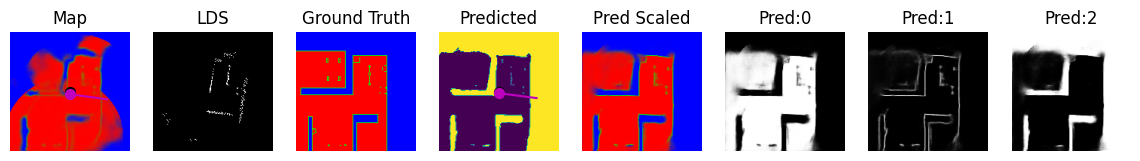

adlo:             [ 1.         -0.02623202 -0.06905483  0.02933878]
adlo-pred raw:    [ 8.328457   -0.02707427 -0.04110995  0.04872344]
adlo-pred scaled: [ 0.99975854 -0.02707427 -0.04110995  0.04872344]
metadata:         [2.0000000e+00 1.0000000e+00 9.9319688e+03 6.1553672e+03 0.0000000e+00
 9.7454883e+03 5.6644639e+03 5.9592706e-01]


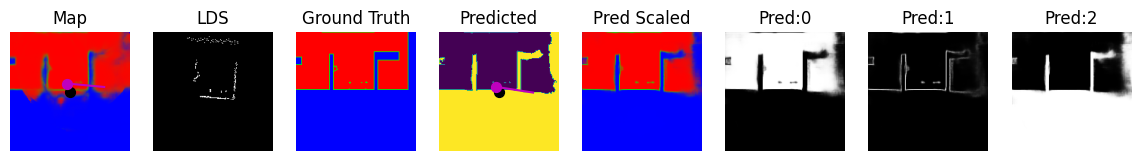

In [ ]:
show_revised_predictions(model, train_data, 8, show_classes='pred')

## Dataset-revisement as Fine-tuning
Instead of supplying a revised dataset every 5 epochs based on the model. Let's compare how training goes if we train against the original dataset entitrely for 100 epochs. And then apply some rounds of fine-tuning against the model-revised dataset.

It's quite probable that revising the input data from such an early phase leads to the model converging more slowly. Thus we might get faster overall results with fine-tuning instead. For example, perhaps 90+10 epochs with fine-tuning as the last 10 would converge faster than 100 with revisement every 5 epochs.

To estimate that effect, we'll train 100 epochs with the original dataset. Then a further 50 with the revised dataset. And we'll estimate the break-even point based on the learning curves.

map_shape: (159, 159, 3)
Added final cropping layer: w=1, h=1
Prepared SLAM model
  Map shape:        (159, 159, 3) + padding (1, 1, 0)
  Skip-connections: concat
  Output scaling:   logits
  DLO encoding:     linear/importance
  Inputs:           [<KerasTensor shape=(None, 159, 159, 3), dtype=float32, sparse=None, name=map_input>, <KerasTensor shape=(None, 159, 159), dtype=float32, sparse=None, name=lds_input>]
  Outputs:          [<KerasTensor shape=(None, 159, 159, 3), dtype=float32, sparse=False, name=keras_tensor_225>, <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_231>]
  Compiled:         True
First 100 epochs with normal training data:


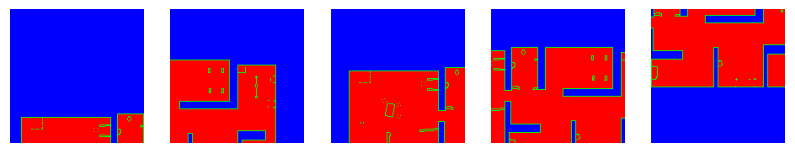

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 597ms/step - adlo_output_accept_accuracy: 0.7169 - adlo_output_adlo_loss: 8.3131 - adlo_output_loc_error: 0.5640 - adlo_output_orientation_error: 1.7724 - loss: 9.1190 - map_output_map_accuracy: 0.6255 - map_output_map_loss: 0.8027 - map_output_obstruction_accuracy: 0.0024
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 363ms/step - adlo_output_accept_accuracy: 0.7237 - adlo_output_adlo_loss: 1.2598 - adlo_output_loc_error: 0.1045 - adlo_output_orientation_error: 0.1868 - loss: 1.9257 - map_output_map_accuracy: 0.7002 - map_output_map_loss: 0.6655 - map_output_obstruction_accuracy: 0.0050
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - adlo_output_accept_accuracy: 0.7429 - adlo_output_adlo_loss: 1.2246 - adlo_output_loc_error: 0.1033 - adlo_output_orientation_error: 0.1832 - loss: 1.8057 - map_output_map_accuracy: 0.7422 - map_output_map_loss: 0.5811 - map_output_obstruction_accuracy: 0.0953
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 371ms/

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step
50 epochs fine-tuning with revised data:


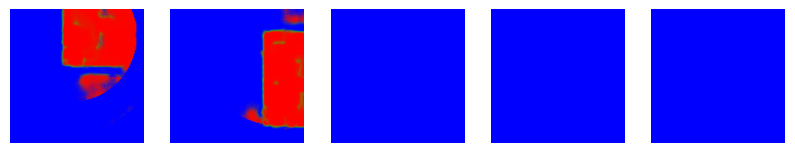

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 621ms/step - adlo_output_accept_accuracy: 0.9804 - adlo_output_adlo_loss: 0.3696 - adlo_output_loc_error: 0.0544 - adlo_output_orientation_error: 0.0857 - loss: 0.7033 - map_output_map_accuracy: 0.8913 - map_output_map_loss: 0.3340 - map_output_obstruction_accuracy: 0.0508
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 394ms/step - adlo_output_accept_accuracy: 0.9244 - adlo_output_adlo_loss: 0.7276 - adlo_output_loc_error: 0.0849 - adlo_output_orientation_error: 0.1412 - loss: 1.1848 - map_output_map_accuracy: 0.8218 - map_output_map_loss: 0.4570 - map_output_obstruction_accuracy: 0.0269
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 398ms/step - adlo_output_accept_accuracy: 0.9387 - adlo_output_adlo_loss: 0.6676 - adlo_output_loc_error: 0.0797 - adlo_output_orientation_error: 0.1432 - loss: 1.0711 - map_output_map_accuracy: 0.8439 - map_output_map_loss: 0.4028 - map_output_obstruction_accuracy: 0.0461
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 393ms/step

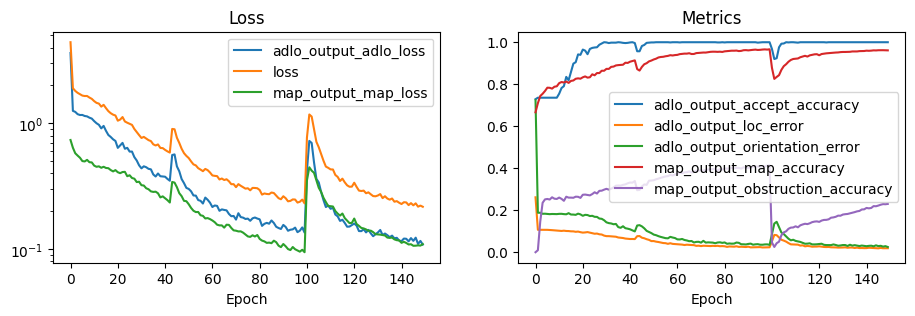

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 6.4548278e+00  6.1225344e-04 -1.7761113e-04  5.3243777e-03]
adlo-pred scaled: [ 9.9842948e-01  6.1225344e-04 -1.7761113e-04  5.3243777e-03]
metadata:         [2.0000000e+00 0.0000000e+00           nan           nan           nan
 7.7704326e+03 5.2244917e+03 2.2490387e+00]


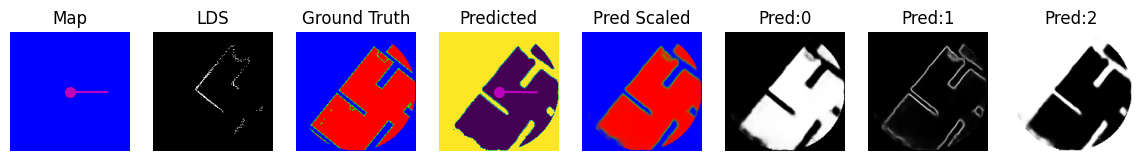

adlo:             [ 1.          0.06650611 -0.1320825  -0.31531525]
adlo-pred raw:    [ 9.915056    0.08641403 -0.12564231 -0.33172736]
adlo-pred scaled: [ 0.9999505   0.08641403 -0.12564231 -0.33172736]
metadata:         [2.0000000e+00 2.0000000e+00 1.2393085e+04 1.5160209e+03 0.0000000e+00
 1.2865870e+04 5.7706079e+02 2.2837534e+00]


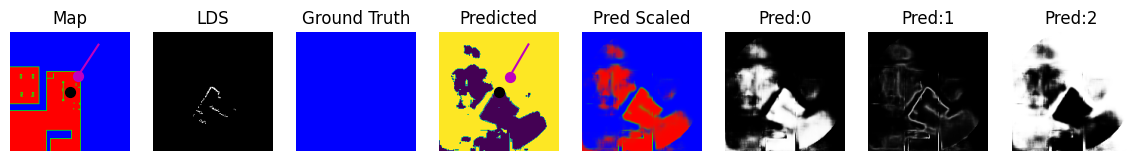

adlo:             [ 1.          0.08753846  0.48659375 -0.07261062]
adlo-pred raw:    [10.296943    0.06527159  0.5366334  -0.06562679]
adlo-pred scaled: [ 0.99996626  0.06527159  0.5366334  -0.06562679]
metadata:         [2.0000000e+00 2.0000000e+00 5.3261099e+03 1.4369366e+03 0.0000000e+00
 5.9484111e+03 4.8960781e+03 1.1705631e+00]


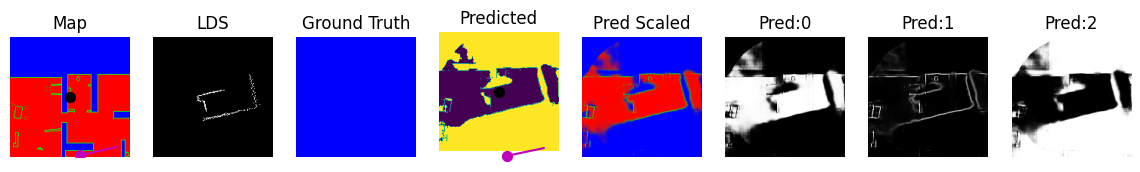

adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 6.4548278e+00  6.1225344e-04 -1.7761113e-04  5.3243777e-03]
adlo-pred scaled: [ 9.9842948e-01  6.1225344e-04 -1.7761113e-04  5.3243777e-03]
metadata:         [2.0000000e+00 0.0000000e+00           nan           nan           nan
 1.1377892e+04 1.6338907e+03 2.9138200e+00]


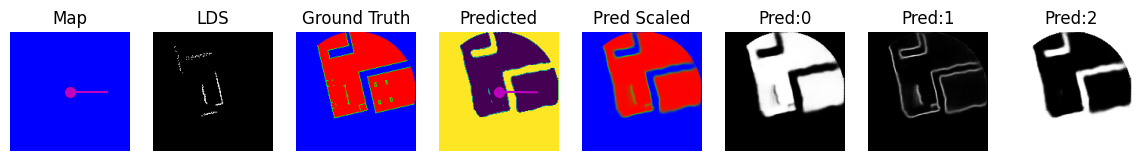

adlo:             [ 1.         -0.04257149 -0.08866958  0.0635903 ]
adlo-pred raw:    [10.865093   -0.03848943 -0.10592938  0.06742366]
adlo-pred scaled: [ 0.9999809  -0.03848943 -0.10592938  0.06742366]
metadata:         [ 2.0000000e+00  1.0000000e+00  3.1065562e+03  5.0983755e+03
  0.0000000e+00  2.8039202e+03  4.4680332e+03 -4.6301708e-01]


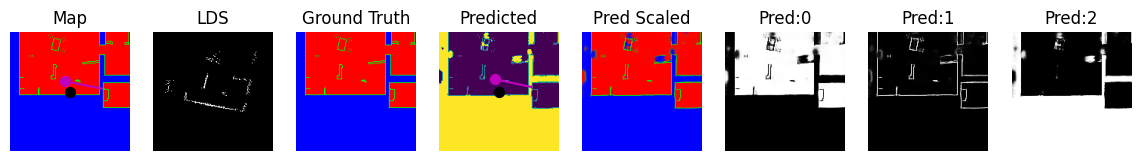

adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 6.4548278e+00  6.1225344e-04 -1.7761113e-04  5.3243777e-03]
adlo-pred scaled: [ 9.9842948e-01  6.1225344e-04 -1.7761113e-04  5.3243777e-03]
metadata:         [ 2.0000000e+00  0.0000000e+00            nan            nan
            nan  9.1949268e+03  1.1775712e+03 -1.0998367e+00]


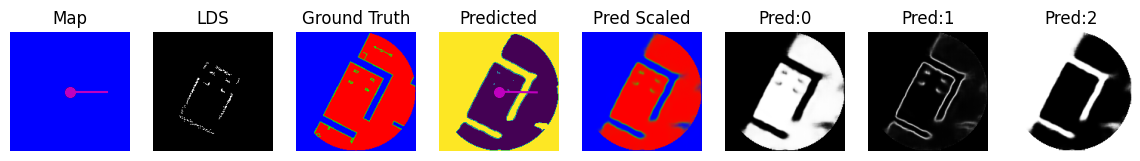

adlo:             [ 1.0000000e+00 -4.5766373e-04  2.0432066e-02  4.3668937e-02]
adlo-pred raw:    [ 9.1709700e+00 -6.6153770e-03  2.1918137e-02  3.8930539e-02]
adlo-pred scaled: [ 0.99989593 -0.00661538  0.02191814  0.03893054]
metadata:         [ 2.0000000e+00  1.0000000e+00  1.1190451e+04  2.4545078e+03
  0.0000000e+00  1.1187198e+04  2.5997571e+03 -5.7919192e-01]


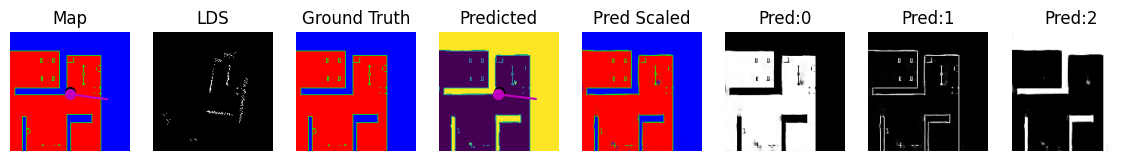

adlo:             [ 1.         -0.02623202 -0.06905483  0.02933878]
adlo-pred raw:    [10.596463   -0.01574401 -0.09042357  0.02824646]
adlo-pred scaled: [ 0.99997497 -0.01574401 -0.09042357  0.02824646]
metadata:         [2.0000000e+00 1.0000000e+00 9.9319688e+03 6.1553672e+03 0.0000000e+00
 9.7454883e+03 5.6644639e+03 5.9592706e-01]


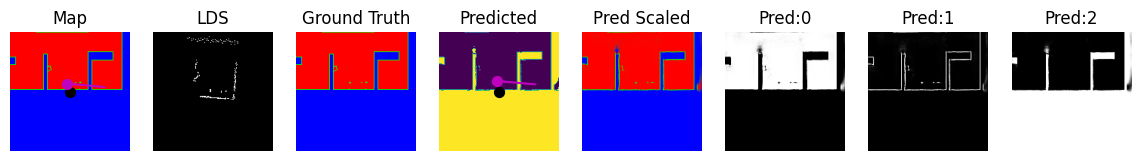

In [ ]:
reload(slam)
reload(slam_data)

one = next(iter(train_data))
map_shape = one[0][0].shape
print(f"map_shape: {map_shape}")
np.random.seed(42)
tf.random.set_seed(42)

epochs1 = 100
epochs2 = 50
batch_size = 32

model = slam.slam_model(map_shape, compile=True, verbose_history=True)
model_train_data = train_data.map(slam_data.for_model_training)\
  .shuffle(buffer_size=len(train_data))\
  .batch(batch_size)\
  .prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
agg_history = tf.keras.callbacks.History()

print(f"First {epochs1} epochs with normal training data:")
show_input_maps(model_train_data)
model_history = model.fit(model_train_data, epochs=epochs1, callbacks=[agg_history])

revisor = slam_data.DatasetRevisor(floorplan, model)
revisor.prepare()
model_train_data = train_data.map(revisor.map).map(slam_data.for_model_training)\
  .shuffle(buffer_size=len(train_data))\
  .batch(batch_size)\
  .prefetch(tf.data.experimental.AUTOTUNE)

print(f"{epochs2} epochs fine-tuning with revised data:")
show_input_maps(model_train_data)
model_history = model.fit(model_train_data, epochs=epochs2, callbacks=[agg_history])
duration = (timer() - start)

print(f"Epochs: {epochs1} + {epochs2}, duration: {duration} sec")
display_history(model_history)
slam_data.show_predictions(model, train_data, 8, show_classes='pred')

Generating 85 LDS maps...
Generating semantic maps...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 6.4548278e+00  6.1225344e-04 -1.7761113e-04  5.3243777e-03]
adlo-pred scaled: [ 9.9842948e-01  6.1225344e-04 -1.7761113e-04  5.3243777e-03]
metadata:         [2.0000000e+00 0.0000000e+00           nan           nan           nan
 7.7704326e+03 5.2244917e+03 2.2490387e+00]


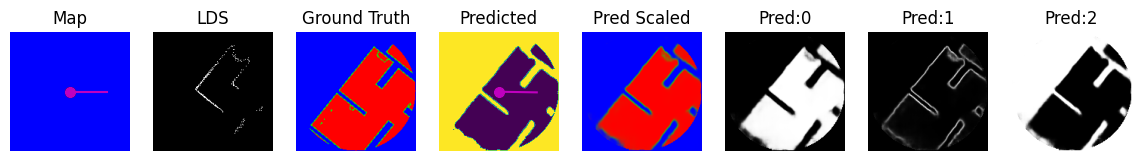

adlo:             [ 1.          0.06650611 -0.1320825  -0.31531525]
adlo-pred raw:    [ 9.986364    0.07942237 -0.14991583 -0.3050448 ]
adlo-pred scaled: [ 0.999954    0.07942237 -0.14991583 -0.3050448 ]
metadata:         [2.0000000e+00 2.0000000e+00 1.2393085e+04 1.5160209e+03 0.0000000e+00
 1.2865870e+04 5.7706079e+02 2.2837534e+00]


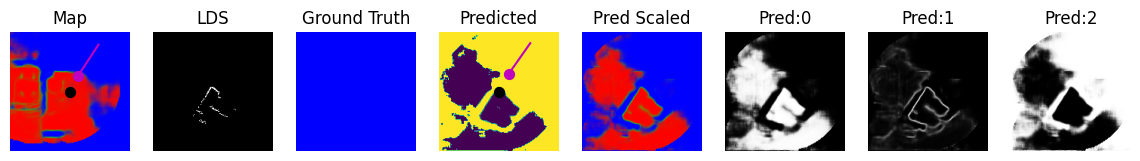

adlo:             [ 1.          0.08753846  0.48659375 -0.07261062]
adlo-pred raw:    [ 8.9490566e+00 -1.4399618e-03  3.2952309e-01 -8.7934412e-02]
adlo-pred scaled: [ 0.9998702  -0.00143996  0.3295231  -0.08793441]
metadata:         [2.0000000e+00 2.0000000e+00 5.3261099e+03 1.4369366e+03 0.0000000e+00
 5.9484111e+03 4.8960781e+03 1.1705631e+00]


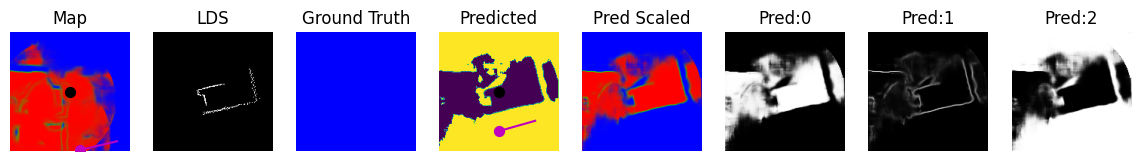

adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 6.4548278e+00  6.1225344e-04 -1.7761113e-04  5.3243777e-03]
adlo-pred scaled: [ 9.9842948e-01  6.1225344e-04 -1.7761113e-04  5.3243777e-03]
metadata:         [2.0000000e+00 0.0000000e+00           nan           nan           nan
 1.1377892e+04 1.6338907e+03 2.9138200e+00]


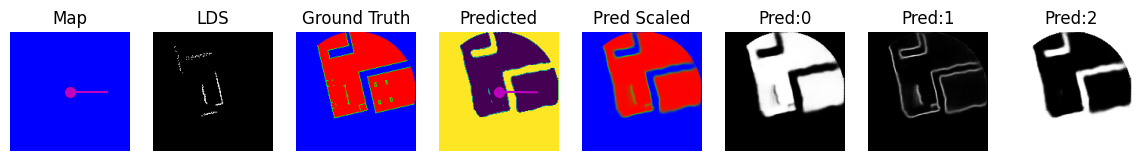

adlo:             [ 1.         -0.04257149 -0.08866958  0.0635903 ]
adlo-pred raw:    [10.055323   -0.03177311 -0.09530527  0.04895212]
adlo-pred scaled: [ 0.9999571  -0.03177311 -0.09530527  0.04895212]
metadata:         [ 2.0000000e+00  1.0000000e+00  3.1065562e+03  5.0983755e+03
  0.0000000e+00  2.8039202e+03  4.4680332e+03 -4.6301708e-01]


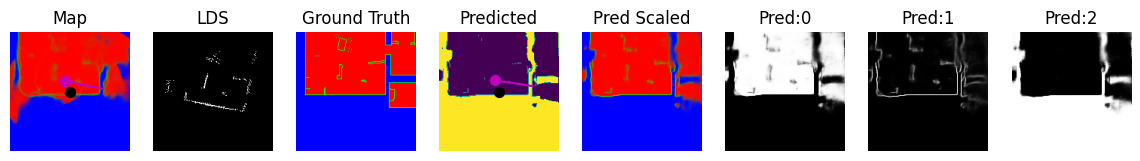

adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 6.4548278e+00  6.1225344e-04 -1.7761113e-04  5.3243777e-03]
adlo-pred scaled: [ 9.9842948e-01  6.1225344e-04 -1.7761113e-04  5.3243777e-03]
metadata:         [ 2.0000000e+00  0.0000000e+00            nan            nan
            nan  9.1949268e+03  1.1775712e+03 -1.0998367e+00]


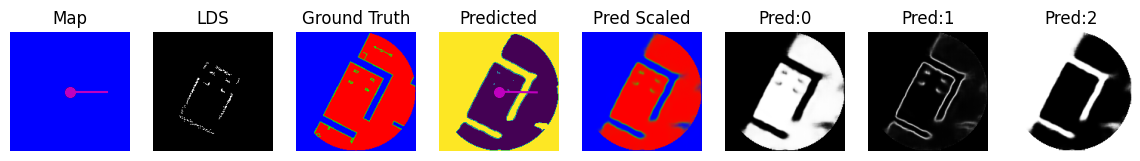

adlo:             [ 1.0000000e+00 -4.5766373e-04  2.0432066e-02  4.3668937e-02]
adlo-pred raw:    [8.7048149e+00 3.2472077e-03 3.1052973e-02 3.8486283e-02]
adlo-pred scaled: [0.9998342  0.00324721 0.03105297 0.03848628]
metadata:         [ 2.0000000e+00  1.0000000e+00  1.1190451e+04  2.4545078e+03
  0.0000000e+00  1.1187198e+04  2.5997571e+03 -5.7919192e-01]


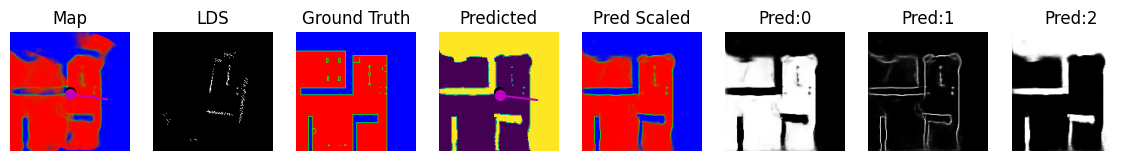

adlo:             [ 1.         -0.02623202 -0.06905483  0.02933878]
adlo-pred raw:    [ 7.251984   -0.0344445  -0.02214877  0.03578993]
adlo-pred scaled: [ 0.99929166 -0.0344445  -0.02214877  0.03578993]
metadata:         [2.0000000e+00 1.0000000e+00 9.9319688e+03 6.1553672e+03 0.0000000e+00
 9.7454883e+03 5.6644639e+03 5.9592706e-01]


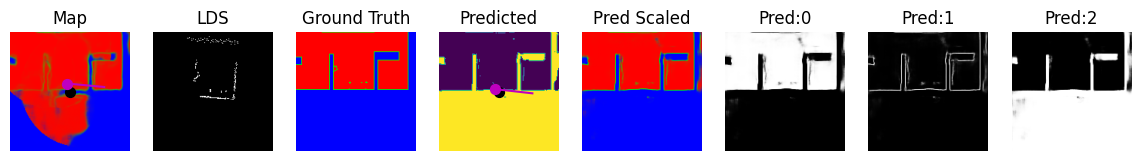

In [ ]:
show_revised_predictions(model, train_data, 8, show_classes='pred')

## Learnings




**Notes**:
* Model-based revisement via fine-tuning performs very badly on a per-epoch and per-time basis. While it is slightly better than the other approach by the end, that's after 150 epochs and 2186 seconds, compared to only 100 epochs and 1979 seconds.
* The fine-tuning step could likely be started earlier, though there's no obvious point from these curves where the best place might be.
* All up, there's very little difference between the two strategies in terms of outcome. With enough hyperparameter tuning we can likely find the best place to start fine-tuning and thus have it complete the same results in about 100 epochs.
* Lastly, there's also the possibility of gradually shifting from initial input maps to predicted input maps. This strikes a nice balance between wanting to use the model earlier to train against its true inputs, while not letting it get too far off track.


Final metrics at end of every-5-epochs version and approximately when they were achieved during the 100+50 version:
* adlo_output_accept_accuracy: 1.0000
* adlo_output_adlo_loss: 0.1777 - achieved @ epoch 116
* adlo_output_loc_error: 0.0322 - achieved @ epoch 114
* adlo_output_orientation_error: 0.0445 - achieved @ epoch 116
* loss: 0.3248 - achieved @ epoch 118
* map_output_map_accuracy: 0.9481 - achieved @ epoch 125
* map_output_map_loss: 0.1470 - achieved @ epoch 126
* map_output_obstruction_accuracy: 0.1634 - achieved @ epoch 126

**Conclusion:**
* I think I'll get best results with a gradual change over to model-predicted inputs, probably about the first 50 epochs should be sufficient, or even doing that over 100 epochs. There doesn't seem to be a noticeable performance disadvantage to doing this, so it seems worthwhile to commit to.




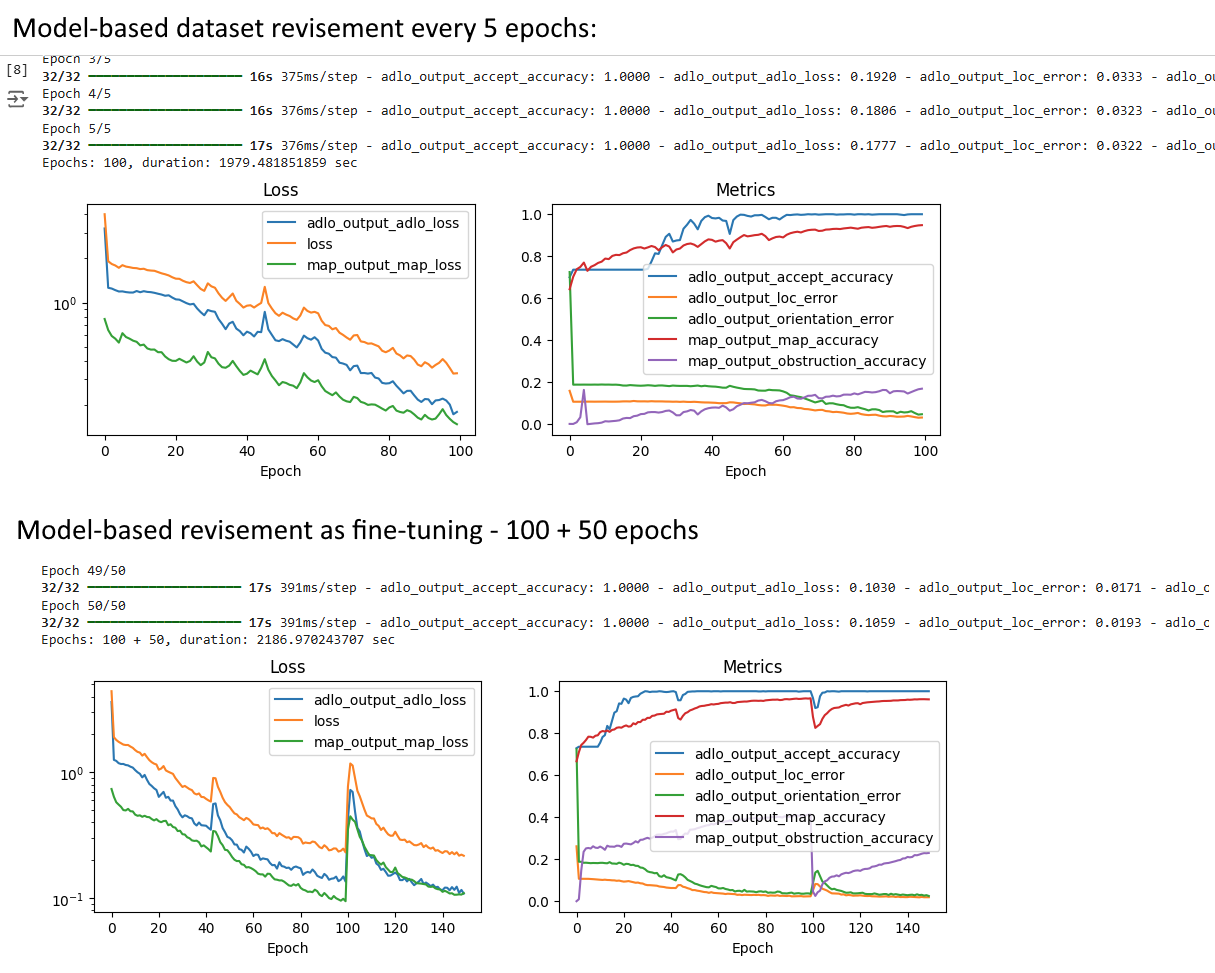

## Appendix: Revising slam_data functions for TF autograph
Some functions need to be TF autograph compatible in order to be used as part of the dataset pipeline:
* `pre_sampled_crop()`
* `combine_semantic_maps()`
* `get_intersect_ranges()`
* `_map_shape()`

In [ ]:
# data prep (if already available)
sample_locations = revisor._sample_locations
sample_maps = revisor._sample_maps
print(f"sample_locations: {sample_locations.shape} x {sample_locations.dtype}")
print(f"sample_maps:      {sample_maps.shape} x {sample_maps.dtype}")

sample_locations: (85, 2) x float64
sample_maps:      (85, 149, 149, 3) x <dtype: 'float32'>


In [ ]:
# _map_shape()
# --> scrapping in favour of inlining into get_interset_ranges_tf()

In [ ]:
# TF version of get_intersect_ranges()
slam_data_test.run_test_suite()
ranges = slam_data.get_intersect_ranges_tf(tf.constant((139, 294)), tf.constant((139, 294)), tf.constant((10, 10)))
print(f"range A: {ranges[0].shape} = {tf.reduce_min(ranges[0],axis=(0,1))} - {tf.reduce_max(ranges[0],axis=(0,1))}")
print(f"range B: {ranges[1].shape} = {tf.reduce_min(ranges[1],axis=(0,1))} - {tf.reduce_max(ranges[1],axis=(0,1))}")

range A: (129, 284, 2) = [10 10] - [138 293]
range B: (129, 284, 2) = [0 0] - [128 283]


locs: <class 'tensorflow.python.framework.ops.EagerTensor'> = (4, 2) x <dtype: 'float64'>
maps: <class 'tensorflow.python.framework.ops.EagerTensor'> = (4, 149, 149, 3) x <dtype: 'float32'>
Any output range:
  start: [   44.71 -2190.79]
  combined: (236, 310, 3) x <dtype: 'float32'> in range [0.        0.        0.1783238] - [0.7763947  0.57274693 1.        ]
  sum: (236, 310) in range 0.9999998807907104 - 1.0000001192092896
Specified output range:
  start: [2235.5     -447.09998]
  combined: (149, 149, 3) x <dtype: 'float32'> in range [0.        0.        0.1783238] - [0.7763947 0.5461913 1.       ]
  sum: (149, 149) in range 0.9999998807907104 - 1.0000001192092896


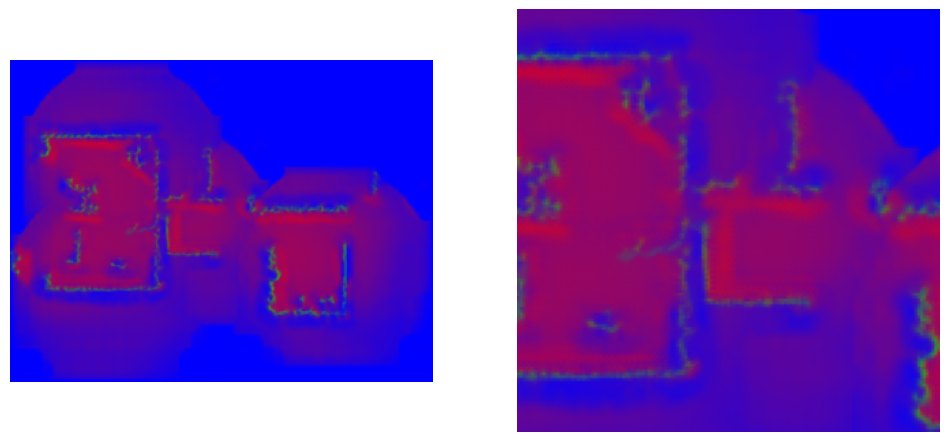

In [ ]:
# TF compatible combine_semantic_maps()
reload(slam_data)
indices = 0, 1, 2, 3
locs = tf.gather(sample_locations, indices)
maps = tf.gather(sample_maps, indices)
print(f"locs: {type(locs)} = {locs.shape} x {locs.dtype}")
print(f"maps: {type(maps)} = {maps.shape} x {maps.dtype}")


def verify(combined, start):
  print(f"  start: {start}")
  print(f"  combined: {combined.shape} x {combined.dtype} in range {tf.reduce_min(combined, axis=(0,1))} - {tf.reduce_max(combined, axis=(0,1))}")
  sm = tf.reduce_sum(combined, axis=-1)
  print(f"  sum: {sm.shape} in range {tf.reduce_min(sm)} - {tf.reduce_max(sm)}")


print(f"Any output range:")
combined1, start1 = slam_data.combine_semantic_maps(locs, maps)
verify(combined1, start1)

print(f"Specified output range:")
out_range = np.array([50, -10, 149, 149])
combined2, start2 = slam_data.combine_semantic_maps(locs, maps, output_range_px=out_range)
verify(combined2, start2)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(combined1)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(combined2)
plt.axis('off')
plt.show()


In [ ]:
reload(slam_data)
def verify(combined, start):
  print(f"  start: {start}")
  print(f"  combined: {combined.shape} x {combined.dtype} in range {tf.reduce_min(combined, axis=(0,1))} - {tf.reduce_max(combined, axis=(0,1))}")
  sm = tf.reduce_sum(combined, axis=-1)
  print(f"  sum: {sm.shape} in range {tf.reduce_min(sm)} - {tf.reduce_max(sm)}")

for i in range(10):
  indices = tf.random.shuffle(tf.range(20))[:3]
  locs = tf.gather(sample_locations, indices)
  maps = tf.gather(sample_maps, indices)

  output_range_px = tf.random.uniform(shape=(2,), minval=-10, maxval=100, dtype=tf.int32)
  output_range_px = [output_range_px[0], output_range_px[1], 149, 149]

  print(f"indices: {indices}")
  combined1, start1 = slam_data.combine_semantic_maps(locs, maps, output_range_px=output_range_px)
  verify(combined1, start1)


indices: [ 2 10  6]
  start: [1430.72   2950.8599]
  combined: (149, 149, 3) x <dtype: 'float32'> in range [0.         0.         0.18668014] - [0.7169624 0.423033  1.       ]
  sum: (149, 149) in range 0.9999998807907104 - 1.0000001192092896
indices: [17 18  3]
  start: [ -44.71   2414.3398]
  combined: (149, 149, 3) x <dtype: 'float32'> in range [0.         0.         0.18587267] - [0.7781585 0.4881626 1.       ]
  sum: (149, 149) in range 0.9999998807907104 - 1.0000001192092896
indices: [ 2 13 19]
  start: [4113.32 2280.21]
  combined: (149, 149, 3) x <dtype: 'float32'> in range [0.         0.         0.18668014] - [0.7296207  0.45407522 1.        ]
  sum: (149, 149) in range 0.9999998807907104 - 1.0000001192092896
indices: [11  0 19]
  start: [-357.68 1743.69]
  combined: (149, 149, 3) x <dtype: 'float32'> in range [0.         0.         0.17111194] - [0.77630776 0.5357618  1.        ]
  sum: (149, 149) in range 0.9999998807907104 - 1.0000001192092896
indices: [10  0  2]
  start: [

combined: (149, 149, 3) x <dtype: 'float32'> in range [0.         0.         0.15455103] - [0.8097343  0.45294347 1.        ]


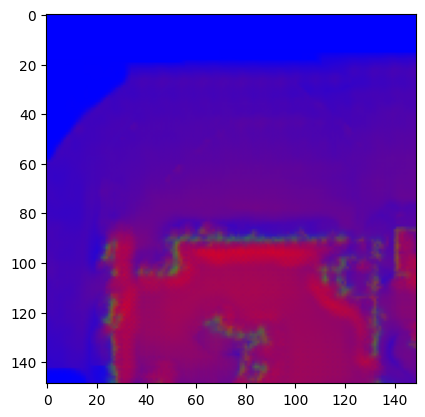

In [ ]:
# TF compatible pre_sampled_crop()
centre = tf.constant([50.0, -10.0]) * lds.__PIXEL_SIZE__
size_px = tf.constant([149, 149])
combined = slam_data.pre_sampled_crop(centre, size_px, sample_locations, sample_maps, sampling_mode='centre-first', max_samples=5)
print(f"combined: {combined.shape} x {combined.dtype} in range {tf.reduce_min(combined, axis=(0,1))} - {tf.reduce_max(combined, axis=(0,1))}")
plt.imshow(combined)
plt.show()

## Appendix: History combining function
For model training with data revision, we need to combine histories between multiple runs.

In [ ]:
# Generate a synthetic dataset
def generate_dataset(num_samples=1000):
    # Class 1: Points around (0, 0)
    class1 = np.random.randn(num_samples // 2, 2) * 0.5
    labels1 = np.zeros((num_samples // 2,), dtype=np.int32)

    # Class 2: Points around (2, 2)
    class2 = np.random.randn(num_samples // 2, 2) * 0.5 + np.array([2, 2])
    labels2 = np.ones((num_samples // 2,), dtype=np.int32)

    # Combine the classes
    features = np.vstack((class1, class2)).astype(np.float32)
    labels = np.concatenate((labels1, labels2))

    # Create a TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.shuffle(buffer_size=num_samples).batch(32)
    return dataset

# Create the dataset
dataset = generate_dataset()

In [ ]:
def create_simple_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(16, activation='relu', input_shape=(2,)),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Create the model
model = create_simple_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


first model_history:
  instance: <keras.src.callbacks.history.History object at 0x7bcc938dab60>
  params:   {'verbose': 0, 'epochs': 20, 'steps': 32}
  model:    <Sequential name=sequential_5, built=True>
  history:  dict_keys(['accuracy', 'loss'])
  accuracy: 60, start: 0.6880000233650208, end: 1.0
  loss: 60, start: 0.6463918685913086, end: 0.0019891925621777773
last model_history:
  instance: <keras.src.callbacks.history.History object at 0x7bcc938dab60>
  params:   {'verbose': 0, 'epochs': 20, 'steps': 32}
  model:    <Sequential name=sequential_5, built=True>
  history:  dict_keys(['accuracy', 'loss'])
  accuracy: 60, start: 0.6880000233650208, end: 1.0
  loss: 60, start: 0.6463918685913086, end: 0.0019891925621777773
agg_history:
  instance: <keras.src.callbacks.history.History object at 0x7bcc938dab60>
  params:   {'verbose': 0, 'epochs': 20, 'steps': 32}
  model:    <Sequential name=sequential_5, built=True>
  history:  dict_keys(['accuracy', 'loss'])
  accuracy: 60, start: 0.6

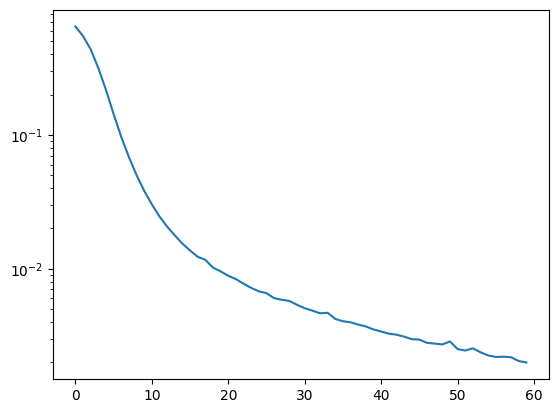

In [ ]:
def history_info(history):
  print(f"  instance: {history}")
  print(f"  params:   {history.params}")
  print(f"  model:    {history.model}")
  print(f"  history:  {history.history.keys()}")
  for k in history.history.keys():
    print(f"  {k}: {len(history.history[k])}, start: {history.history[k][0]}, end: {history.history[k][-1]}")

# create new model
model = create_simple_model()

# train multiple times
agg_history = tf.keras.callbacks.History()
first_history = None
for i in range(3):
  model_history = model.fit(dataset, epochs=20, callbacks=[agg_history], verbose=0)
  if first_history is None:
    first_history = model_history
last_history = model_history

# compare history objects
print("first model_history:")
history_info(first_history)
print("last model_history:")
history_info(last_history)
print("agg_history:")
history_info(agg_history)

plt.plot(agg_history.history['loss'])
plt.yscale('log')
plt.show()